In [23]:
from torch_geometric.data import Data
import torch_geometric.nn as gnn
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch_geometric
import networkx as nx
import pyvis
import matplotlib.pyplot as plt
import numpy as np

import srunner

from pathlib import Path
from typing import Protocol, cast
import enum
import dataclasses
import pickle
import random
import json
import uuid
import logging

In [24]:
logger = logging.getLogger("notebook")
logger.setLevel(logging.DEBUG)
logging.basicConfig(level=logging.DEBUG)
np.seterr(all='raise')
DEV = "cuda"
torch.set_float32_matmul_precision("medium")

writer = SummaryWriter()

@dataclasses.dataclass
class Counters:
    episodes: int = 0 
    epochs: int = 0
    runs: int = 0
    steps: int = 0
    batches: int = 0
    train_steps: int = 0

    def from_dict(self, d):
        for k, v in d.items():
            setattr(self, k, v)

COUNTERS = Counters()

In [25]:
from primitives import Clause

class NodeType(enum.Enum):
    VARIABLE = 0
    REDUNDANT = 1
    IRREDUNDANT = 2

class CnfGraph(Protocol):
    global_data: torch.Tensor
    x: torch.Tensor
    edge_index: torch.Tensor
    edge_attr: torch.Tensor
    node_type: torch.Tensor

@dataclasses.dataclass
class DimInfo:
    num_global_features: int
    num_var_features: int
    num_clause_features: int
    num_edge_features: int

@dataclasses.dataclass
class ReductionProblem:
    num_vars: int
    levels: list[int]
    vals: list[int]
    clauses: list[Clause]
    reducible_ids: list[int]
    conflicts: int

In [26]:
def problem_to_cnf_graph(problem: ReductionProblem) -> tuple[CnfGraph, DimInfo]:
    logger.info("Converting problem to CNF graph")
    num_vars = problem.num_vars

    fixed_vals = [problem.vals[i] if problem.levels[i] == 0 else 0 for i in range(num_vars)]

    clauses = []
    for clause in problem.clauses:
        new_lits = []
        for lit in clause.lits:
            v = abs(lit) - 1
            if fixed_vals[v] == 0:
                new_lits.append(lit)
            elif lit > 0 and fixed_vals[v] == 1 or lit < 0 and fixed_vals[v] == -1:
                break
            # else skip literal because it's falsified
        else:
            clauses.append(clause.with_lits(new_lits))

    num_clauses = len(clauses)
    num_free_vars = sum(1 for v in fixed_vals if v == 0)

    c_clause_sizes = np.array([len(clause.lits) for clause in clauses])
    c_clause_lbd = np.array([clause.lbd for clause in clauses])
    g_max_clause_size = c_clause_sizes.max()
    g_min_clause_size = c_clause_sizes.min()
    g_mean_clause_size = c_clause_sizes.mean()
    g_min_clause_lbd = c_clause_lbd.min()
    g_max_clause_lbd = c_clause_lbd.max()
    g_lbd_spread = g_max_clause_lbd - g_min_clause_lbd
    g_mean_clause_lbd = c_clause_lbd.mean()
    c_lbd_size_ratio = c_clause_lbd / c_clause_sizes
    c_num_pos_literals = np.array([sum(1 for lit in clause.lits if lit > 0) for clause in clauses])
    c_num_neg_literals = c_clause_sizes - c_num_pos_literals
    c_pos_neg_ratios = c_num_pos_literals / c_clause_sizes
    g_max_pos_neg_ratio = c_pos_neg_ratios.max()
    g_min_pos_neg_ratio = c_pos_neg_ratios.min()
    g_mean_pos_neg_ratio = c_pos_neg_ratios.mean()
    c_horn = c_num_pos_literals <= 1
    g_horn_ratio = c_horn.mean()
    c_inv_horn = c_num_neg_literals <= 1
    g_inv_horn_ratio = c_inv_horn.mean()
    g_size_spread = g_max_clause_size - g_min_clause_size
    g_pos_neg_ratio_spread = g_max_pos_neg_ratio - g_min_pos_neg_ratio
    c_conflicts_on_creation = np.array([clause.conflicts_on_creation for clause in clauses])
    c_time = c_conflicts_on_creation / problem.conflicts
    c_activity = np.array([clause.activity for clause in clauses], dtype=np.float32)
    c_activity /= max(c_activity.max(), 1.0)
    c_activity_top10 = c_activity > np.percentile(c_activity, 90)
    c_time_top10 = c_time > np.percentile(c_time, 90)
    c_times_reason = np.array([clause.times_reason for clause in clauses], dtype=np.float32)
    c_times_reason /= max(c_times_reason.max(), 1.0)
    c_times_reason_top10 = c_times_reason > np.percentile(c_times_reason, 90)


    v_pos = np.zeros(num_vars)
    v_neg = np.zeros(num_vars)
    v_horn = np.zeros(num_vars)
    v_invhorn = np.zeros(num_vars)

    for i, clause in enumerate(clauses):
        for lit in clause.lits:
            v = abs(lit) - 1
            if lit > 0:
                v_pos[v] += 1
            else:
                v_neg[v] += 1
            if c_horn[i]:
                v_horn[v] += 1
            if c_inv_horn[i]:
                v_invhorn[v] += 1

    v_count = v_pos + v_neg
    v_count_non_zero = np.maximum(v_count, 1)
    v_pos_neg_ratios = v_pos / v_count_non_zero
    v_horn_ratio = v_horn / v_count_non_zero
    v_invhorn_ratio = v_invhorn / v_count_non_zero
    g_var_horn_min = v_horn.min()
    g_var_horn_max = v_horn.max()
    g_var_horn_mean = v_horn.mean()
    g_var_invhorn_min = v_invhorn.min()
    g_var_invhorn_max = v_invhorn.max()
    g_var_invhorn_mean = v_invhorn.mean()
    g_var_horn_std = v_horn.std()
    g_var_invhorn_std = v_invhorn.std()
    g_var_pos_neg_ratio_std = v_pos_neg_ratios.std()
    g_var_count_std = v_count.std()
    g_var_clause_ratio = num_free_vars / num_clauses
    g_free_ratio = num_free_vars / num_vars

    c_clause_keep = np.array([clause.keep for clause in clauses])
    c_clause_redundant = np.array([clause.redundant for clause in clauses])

    global_features = [
        g_mean_clause_size,
        g_mean_clause_lbd,
        g_mean_pos_neg_ratio,
        g_horn_ratio,
        g_inv_horn_ratio,
        g_var_horn_mean,
        g_var_invhorn_mean,
        g_var_horn_std,
        g_var_invhorn_std,
        g_var_pos_neg_ratio_std,
        g_var_count_std,
        g_var_clause_ratio,
        g_free_ratio,
    ]

    clause_features = [
        c_clause_sizes,
        c_clause_sizes / num_vars,
        (c_clause_sizes - g_min_clause_size) / g_size_spread if g_size_spread > 0 else 0,
        c_clause_lbd,
        (c_clause_lbd - g_min_clause_lbd) / g_lbd_spread if g_lbd_spread > 0 else 0,
        c_lbd_size_ratio,
        c_pos_neg_ratios,
        c_horn,
        c_inv_horn,
        c_clause_redundant,
        c_clause_keep,
        c_time,
        c_time_top10,
        c_activity,
        c_activity_top10,
        c_times_reason,
        c_times_reason_top10,
    ]

    var_features = [
        v_pos,
        v_neg,
        v_pos_neg_ratios,
        v_horn,
        v_invhorn,
        v_horn_ratio,
        v_invhorn_ratio,
    ]

    embedding_size = max(len(var_features), len(clause_features))

    global_data = torch.tensor(global_features, dtype=torch.float32)
    x = torch.zeros(num_vars + num_clauses, embedding_size)
    edge_index = []
    edge_attr = []
    node_type = torch.zeros(num_vars + num_clauses, dtype=torch.int8)

    node_type[:num_vars] = NodeType.VARIABLE.value
    node_type[num_vars:] = NodeType.IRREDUNDANT.value

    reducible_ids = set(problem.reducible_ids)

    for i, clause in enumerate(clauses):
        if clause.id_ in reducible_ids:
            node_type[num_vars + i] = NodeType.REDUNDANT.value

    for i, f in enumerate(var_features):
        x[:num_vars, i] = torch.tensor(f, dtype=torch.float32)

    for i, f in enumerate(clause_features):
        x[num_vars:, i] = torch.tensor(f, dtype=torch.float32)

    for i, clause in enumerate(clauses):
        for lit in clause.lits:
            v = abs(lit) - 1
            edge_index.append((v, num_vars + i))
            edge_attr.append(-1 if lit < 0 else 1)

    edge_attr = torch.tensor(edge_attr, dtype=torch.float32).view(-1, 1)

    logger.info("Finished converting problem to CNF graph")

    return cast(CnfGraph, Data(
        global_data=global_data,
        x=x,
        edge_index=torch.tensor(edge_index, dtype=torch.int64).t(),
        edge_attr=edge_attr,
        node_type=node_type,
    )), DimInfo(
        num_clause_features=len(clause_features),
        num_edge_features=edge_attr.size(dim=1),
        num_global_features=len(global_features),
        num_var_features=len(var_features),
    )


def ordered_reducible_ids(problem: ReductionProblem) -> list[int]:
    reducible_ids = set(problem.reducible_ids)
    return [clause.id_ for clause in problem.clauses if clause.id_ in reducible_ids]

In [27]:
minimal_example_data, DIM_INFO = problem_to_cnf_graph(ReductionProblem(
    2,
    [1, 1],
    [0, 0],
    [
        Clause(0, [1, 2], 0, False, True, False),
        Clause(5, [-1, -2], 0, False, False, False),
        Clause(8, [-1, 2], 0, False, False, False),
    ],
    [5, 8],
    3,
))

print(DIM_INFO)

INFO:notebook:Converting problem to CNF graph
INFO:notebook:Finished converting problem to CNF graph


DimInfo(num_global_features=13, num_var_features=7, num_clause_features=17, num_edge_features=1)


INFO:notebook:Converting problem to CNF graph


INFO:notebook:Finished converting problem to CNF graph


<BarContainer object of 4 artists>

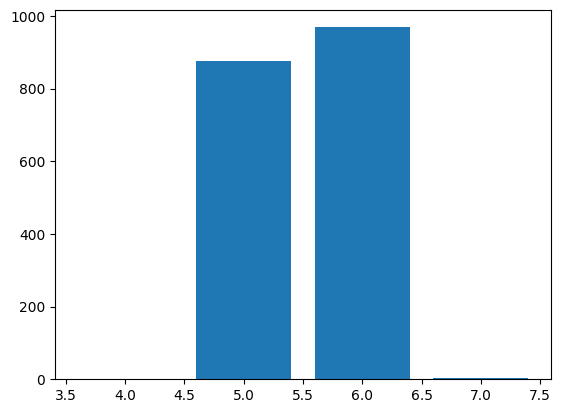

In [28]:
with open("../archives/example-problem.pkl", "rb") as f:
    problem = pickle.load(f)

example_data, _ = problem_to_cnf_graph(problem)

nx_graph = torch_geometric.utils.to_networkx(example_data, to_undirected=True)

g = pyvis.network.Network(width=1800, height=1000, cdn_resources='in_line')
g.toggle_hide_edges_on_drag = True
g.barnes_hut()
g.from_nx(nx_graph)
g.save_graph("example.html")

eccentricities = list(nx.eccentricity(nx_graph).values())
plt.bar(*np.unique(eccentricities, return_counts=True))

In [29]:
class CnfProcessingBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, edge_dim: int, disambiguate_clauses: bool):
        super().__init__()

        self.disambiguate_clauses = disambiguate_clauses

        if disambiguate_clauses:
            self.conv_redundant = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)
            self.conv_irredundant = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)
        else:
            self.conv_clauses = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)

        self.conv_variables = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, h, data):
        edge_index, edge_attr, node_type = data.edge_index, data.edge_attr, data.node_type

        out = torch.zeros_like(h)

        variable_mask = (node_type == NodeType.VARIABLE.value)
        out[variable_mask, :] = self.conv_variables(h, edge_index, edge_attr)[variable_mask, :]

        if self.disambiguate_clauses:
            redundant_mask = (node_type == NodeType.REDUNDANT.value)
            irredundant_mask = (node_type == NodeType.IRREDUNDANT.value)

            out[redundant_mask, :] = self.conv_redundant(h, edge_index, edge_attr)[redundant_mask, :]
            out[irredundant_mask, :] = self.conv_irredundant(h, edge_index, edge_attr)[irredundant_mask, :]
        else:
            clause_mask = (node_type != NodeType.VARIABLE.value)

            out[clause_mask] = self.conv_clauses(h, edge_index, edge_attr)[clause_mask, :]


        out = self.activation(out)

        return out

In [30]:
class ExpectedValueNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, p: torch.Tensor, ex: torch.Tensor):
        ex = torch.as_tensor(ex)

        gamma = torch.ones(p.shape[:-1], device=p.device)

        for _ in range(10):
            normalized = p ** gamma.unsqueeze(-1)
            f_gamma = normalized.sum(dim=-1) - ex
            f_prime_gamma = (normalized * p.log()).sum(dim=-1)
            new_gamma = gamma - f_gamma / f_prime_gamma
            gamma = torch.maximum(new_gamma, gamma / 10)

        normalized = p ** gamma.unsqueeze(-1)
        ctx.save_for_backward(p, normalized, gamma)
        return normalized

    @staticmethod
    def backward(ctx, grad_output):
        p, normalized, gamma = ctx.saved_tensors

        normalized_dp = normalized * p.log()
        denom = normalized_dp.sum(dim=-1)

        jac = (
            torch.diag_embed(gamma.unsqueeze(-1) * normalized / p) -
            (gamma / denom).unsqueeze(-1).unsqueeze(-1) * normalized_dp.unsqueeze(-2) * (normalized / p).unsqueeze(-1)
        )

        return (jac @ grad_output.unsqueeze(-1)).squeeze(-1), None


"""
x = torch.tensor([
    [1., 0.5, 0.5, 0.5, 0.1],
    [0.3, 0.5, 0.5, 0.8, 0.2],
], requires_grad=True)
optim = torch.optim.SGD([x], lr=0.1)
for _ in range(100):
    optim.zero_grad()
    y = ExpectedValueNormalization.apply(x, torch.tensor([2.0, 1.0]))
    loss = y.pow(3.0).sum()
    loss.backward()
    optim.step()
    print(x.sum(axis=1))
"""

'\nx = torch.tensor([\n    [1., 0.5, 0.5, 0.5, 0.1],\n    [0.3, 0.5, 0.5, 0.8, 0.2],\n], requires_grad=True)\noptim = torch.optim.SGD([x], lr=0.1)\nfor _ in range(100):\n    optim.zero_grad()\n    y = ExpectedValueNormalization.apply(x, torch.tensor([2.0, 1.0]))\n    loss = y.pow(3.0).sum()\n    loss.backward()\n    optim.step()\n    print(x.sum(axis=1))\n'

In [31]:
class ExpectedValueNormalizationLogits(torch.autograd.Function):
    @staticmethod
    def forward(ctx, logits: torch.Tensor, ex: torch.Tensor):
        ex = torch.as_tensor(ex)

        b = torch.zeros(logits.shape[:-1], device=logits.device)

        for _ in range(100):
            normalized = torch.sigmoid(logits + b.unsqueeze(-1))
            f_gamma = normalized.sum(dim=-1) - ex
            f_prime_gamma = (normalized * (1 - normalized)).sum(dim=-1)
            diff = torch.clamp(f_gamma / f_prime_gamma, -2, 2)
            if torch.all(diff.abs() < 1e-6):
                break
            b = b - diff

        normalized = torch.sigmoid(logits + b.unsqueeze(-1))
        ctx.save_for_backward(normalized)
        return normalized

    @staticmethod
    def backward(ctx, g):
        normalized, = ctx.saved_tensors
        p_grad = normalized * (1 - normalized)
        denom = p_grad.sum(dim=-1)
        coordwise = p_grad * g

        grad = coordwise - p_grad * coordwise.sum(axis=-1).unsqueeze(-1) / denom.unsqueeze(-1)

        return grad, None


probs = torch.tensor([
    [0.999, 0.5, 0.5, 0.5, 0.1],
    [0.3, 0.5, 0.5, 0.8, 0.2],
], requires_grad=True)
x = -(1 / probs - 1).log()
y = ExpectedValueNormalizationLogits.apply(x, torch.tensor([2.0, 1.0]))
# print(x, y, y.sum(axis=-1), sep="\n")
y.sum().backward()
# print(probs.grad)

optim = torch.optim.SGD([probs], lr=0.1)
for _ in range(100):
    optim.zero_grad()
    x = -(1 / probs - 1).log()
    y = ExpectedValueNormalizationLogits.apply(x, torch.tensor([2.0, 1.0]))
    loss = y.pow(3.0).sum()
    loss.backward()
    optim.step()
    # print(probs)

In [32]:
class CnfGraphModel(nn.Module):
    def __init__(
        self,
        input_global_dim: int,
        input_variable_dim: int,
        input_clause_dim: int,
        hidden_dims: list[int],
        disambiguate_clauses_in_first: int = 2,
        edge_dim: int = 1,
    ):
        super().__init__()

        self.input_variable_dim = input_variable_dim
        self.input_clause_dim = input_clause_dim

        self.variable_fc = nn.Linear(input_global_dim + input_variable_dim, hidden_dims[0])
        self.clause_fc = nn.Linear(input_global_dim + input_clause_dim, hidden_dims[0])

        self.silu = nn.SiLU()

        self.processing_blocks = nn.ModuleList([
            CnfProcessingBlock(
                hidden_dims[i],
                hidden_dims[i + 1],
                edge_dim,
                i < disambiguate_clauses_in_first
            )
            for i in range(len(hidden_dims) - 1)
        ])

        self.output_fc = nn.Linear(hidden_dims[-1], 1, bias=False)

        self.value_fc_clauses = nn.Linear(hidden_dims[-1], 1, bias=False)
        self.value_fc_variables = nn.Linear(hidden_dims[-1], 1)

    def forward(self, cnf_graph: CnfGraph, ex: torch.Tensor | float):
        logger.info("Starting model forward pass")

        num_vertices = cnf_graph.x.shape[0]
        variable_mask = (cnf_graph.node_type == NodeType.VARIABLE.value)
        num_variables = variable_mask.sum()

        variable_input = torch.cat([
            cnf_graph.global_data.expand(num_variables, -1),
            cnf_graph.x[:num_variables, :self.input_variable_dim],
        ], dim=-1)

        variable_embedding = self.silu(self.variable_fc(variable_input))

        clause_input = torch.cat([
            cnf_graph.global_data.expand(num_vertices - num_variables, -1),
            cnf_graph.x[num_variables:, :self.input_clause_dim],
        ], dim=-1)

        clause_embedding = self.silu(self.clause_fc(clause_input))

        x = torch.cat([variable_embedding, clause_embedding], dim=0)

        for block in self.processing_blocks:
            x = block(x, cnf_graph)

        logits = self.output_fc(x[cnf_graph.node_type == NodeType.REDUNDANT.value]).view(-1)
        # logits = (logits - logits.mean()) / logits.std()
        # assert not torch.isnan(logits).any()
        # denorm_probs = torch.sigmoid(logits)
        # assert not torch.isnan(denorm_probs).any()
        # probs = ExpectedValueNormalization.apply(denorm_probs, ex)
        # if torch.isnan(probs).any():
        #     print(denorm_probs)
        #     print(probs)
        #     raise AssertionError()
        probs = ExpectedValueNormalizationLogits.apply(logits, ex)
        if torch.isnan(probs).any():
            print(logits)
            print(probs)
            raise AssertionError()

        value_vars = self.value_fc_variables(x[variable_mask])
        value_clauses = self.value_fc_clauses(x[~variable_mask])
        value = torch.cat([value_vars, value_clauses]).mean()

        logger.info("Finished model forward pass")

        return probs, value

In [33]:
testing_model = CnfGraphModel(
    input_global_dim=DIM_INFO.num_global_features,
    input_variable_dim=DIM_INFO.num_var_features,
    input_clause_dim=DIM_INFO.num_clause_features,
    edge_dim=DIM_INFO.num_edge_features,
    hidden_dims=[32, 32, 32, 32],
)

testing_model(minimal_example_data, 0.75)

INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass


(tensor([0.3754, 0.3746], grad_fn=<ExpectedValueNormalizationLogitsBackward>),
 tensor(0.1029, grad_fn=<MeanBackward0>))

In [34]:
@dataclasses.dataclass
class Hyperparameters:
    batch_size: int = 64
    runs_per_episode: int = 16
    epochs: int = 4
    learning_rate: float = 3e-4
    eps_clip: float = 0.2
    entropy_coef: float = 0.01
    weight_decay: float = 1e-3
    value_weight: float = 0.5
    policy_weight: float = 1.0
    gae_gamma: float = 0.99
    gae_lambda: float = 0.95
    penalty_per_conflict: float = 5e-5


HP = Hyperparameters()


In [35]:
def compute_returns_advantages(rewards: list[float], values: list[float]) -> tuple[list[float], list[float]]:
    returns = []
    advantages = []
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + HP.gae_gamma * (values[i + 1] if i + 1 < len(values) else 0) - values[i]
        gae = delta + HP.gae_gamma * HP.gae_lambda * gae
        returns.append(gae + values[i])
        advantages.append(gae)
    return returns[::-1], advantages[::-1]

In [36]:
@dataclasses.dataclass
class EpisodeResult:
    states: list[CnfGraph]
    dists: list[torch.distributions.Bernoulli]
    actions: list[torch.Tensor]
    rewards: list[float]
    values: list[float]
    returns: list[float]
    advantages: list[float]

    stats: list[dict]

    @staticmethod
    def empty() -> 'EpisodeResult':
        return EpisodeResult([], [], [], [], [], [], [], [])

    def merge_with(self, other: 'EpisodeResult') -> 'EpisodeResult':
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards) == len(self.returns) ==
            len(self.advantages)
        )
        assert (
            len(other.states) == len(other.dists) == len(other.actions) ==
            len(other.values) == len(other.rewards) == len(other.returns) ==
            len(other.advantages)
        )
        return EpisodeResult(
            self.states + other.states,
            self.dists + other.dists,
            self.actions + other.actions,
            self.rewards + other.rewards,
            self.values + other.values,
            self.returns + other.returns,
            self.advantages + other.advantages,
            self.stats + other.stats,
        )

    @staticmethod
    def merge_all(results: list['EpisodeResult']) -> 'EpisodeResult':
        result = results[0]
        for other in results[1:]:
            result = result.merge_with(other)
        return result

    def add(self, *, state, dist, action, reward, value):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards)
        )
        self.states.append(state)
        self.dists.append(dist)
        self.actions.append(action)
        if reward is not None:
            self.rewards.append(reward)
        self.values.append(value)

    def add_reward(self, reward):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards) + 1
        )
        self.rewards.append(reward)

    def complete(self, stats: dict):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards)
        )
        assert len(self.stats) == 0
        self.returns, self.advantages = compute_returns_advantages(self.rewards, self.values)
        self.stats = [stats]


In [37]:
class Agent:
    def __init__(self, model):
        self.model = model.to(DEV)
        self.optim = torch.optim.AdamW(
            self.model.parameters(),
            lr=HP.learning_rate,
            weight_decay=HP.weight_decay
        )

    def act(self, cnf_graph: CnfGraph, ex: float):
        COUNTERS.steps += 1
        logger.info("Running agent act")
        with torch.no_grad():
            cnf_graph = cnf_graph.to(DEV)
            assert torch.isnan(cnf_graph.x).sum() == 0
            assert torch.isnan(cnf_graph.edge_attr).sum() == 0
            assert torch.isnan(cnf_graph.global_data).sum() == 0
            probs, value = self.model(cnf_graph, ex)
            logger.info("Finished agent act")
            return torch.distributions.Bernoulli(probs), value.item()

    def update(self, results: EpisodeResult, silent: bool = False):
        logger.info("Training agent")
        r = results

        n = len(r.states)
        batch_size = HP.batch_size
        for num_epoch in range(HP.epochs):
            COUNTERS.epochs += 1
            logger.info("Training agent, epoch %d", num_epoch)
            indices = random.sample(range(n), n)
            for batch_start in range(0, n, batch_size):
                COUNTERS.batches += 1
                idx = indices[batch_start:batch_start + batch_size]

                self.optim.zero_grad()
                for i in idx:
                    COUNTERS.train_steps += 1
                    graph, ex = r.states[i]
                    new_probs, value = self.model(graph, ex)
                    value = value.cpu()
                    dist = torch.distributions.Bernoulli(probs=new_probs)
                    log_probs = dist.log_prob(r.actions[i].float())
                    entropy = dist.entropy().sum()

                    ratio = torch.exp(log_probs - r.dists[i].log_prob(r.actions[i].float()))
                    surr1 = ratio * r.advantages[i]
                    surr2 = torch.clamp(ratio, 1.0 - HP.eps_clip, 1.0 + HP.eps_clip) * r.advantages[i]

                    value_loss = torch.nn.functional.huber_loss(value, torch.tensor(r.rewards[i] + r.values[i]))
                    policy_loss = -torch.min(surr1, surr2).mean()

                    if not silent:
                        writer.add_scalar("value loss", value_loss.item(), COUNTERS.train_steps)

                    loss = (
                        HP.policy_weight * policy_loss
                        + HP.value_weight * value_loss
                        - HP.entropy_coef * entropy
                    ) / len(idx)

                    loss.backward()

                self.optim.step()

In [38]:
testing_agent = Agent(testing_model)

states = [
    (minimal_example_data, 0.75),
    (minimal_example_data, 0.5),
    (minimal_example_data, 0.25),
]

dist1, value1 = testing_agent.act(*states[0])
dist2, value2 = testing_agent.act(*states[1])
dist3, value3 = testing_agent.act(*states[2])

dists = [dist1, dist2, dist3]
values = [value1, value2, value3]
print(values)

actions = [dist.sample() > 0.5 for dist in dists]
rewards = [-1.0, -1.0, 10.0]

returns, advantages = compute_returns_advantages(rewards, [1.0, 1.0, 1.0])
print(advantages)

results = EpisodeResult(
    states,
    dists,
    actions,
    rewards,
    values,
    returns,
    advantages,
    [],
)

testing_agent.update(results, silent=True)


INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Training agent
INFO:notebook:Training agent, epoch 0
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Training agent, epoch 1
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model

[0.10288997739553452, 0.10288997739553452, 0.10288997739553452]
[6.00095725, 7.4544999999999995, 9.0]


In [39]:
@dataclasses.dataclass
class CnfProblemInstance:
    result: bool
    path: Path
    stats: dict[str, any]
    stats_no_reductions: dict[str, any]


with open("../archives/runs.json", "r") as f:
    runs = [json.loads(line) for line in f.readlines()]
    runs = [CnfProblemInstance(
        result=run["result"],
        path=Path(run["path"]),
        stats=run["stats"],
        stats_no_reductions=run["stats_no_reductions"],
    ) for run in runs]


def get_random_instance(unsat_only: bool = True) -> CnfProblemInstance:
    while True:
        run = random.choice(runs)
        if not unsat_only or not run.result:
            return run

In [40]:
class CadicalEnv:
    def __init__(
        self,
        cadical_path: Path,
        runs_per_episode: int = 16,
    ):
        self.cadical_path = cadical_path
        self.runs_per_episode = runs_per_episode

    def run_instance(self, agent: Agent, instance: CnfProblemInstance) -> EpisodeResult:
        COUNTERS.runs += 1
        result = EpisodeResult.empty()
        router = srunner.Router()

        reduce_number = 0
        last_conflicts = 0

        @router.route("reduce")
        def _reduce_route(conn: srunner.Connection, info: srunner.RunInfo, _data):
            nonlocal reduce_number
            nonlocal last_conflicts

            logger.info("Received clause database reduction")

            num_vars = conn.read_u64()
            levels = [-1] * num_vars
            vals = [-1] * num_vars
            for i in range(num_vars):
                vals[i] = conn.read_i8()
                levels[i] = conn.read_i32()
            num_clauses = conn.read_u64()
            clauses = [conn.read_clause() for _ in range(num_clauses)]
            num_reducible = conn.read_u64()
            num_target = conn.read_u64()
            reducible_ids = [conn.read_u64() for _ in range(num_reducible)]
            conflicts = conn.read_u64()
            conn.write_ok()

            if reduce_number != 0:
                result.add_reward(-(conflicts - last_conflicts) * HP.penalty_per_conflict)
            last_conflicts = conflicts

            problem = ReductionProblem(
                num_vars=num_vars,
                levels=levels,
                vals=vals,
                clauses=clauses,
                reducible_ids=reducible_ids,
                conflicts=conflicts,
            )

            logger.debug("Finished reading reduction data")

            cnf, dim_info = problem_to_cnf_graph(problem)
            assert dim_info == DIM_INFO

            ex = float(num_target)

            logger.debug("Converted problem to CNF graph")

            dist, value = agent.act(cnf, ex)
            action = dist.sample()

            logger.debug("Agent acted")

            result.add(
                state=(cnf, ex),
                dist=dist,
                action=action,
                reward=None,
                value=value,
            )

            logger.debug("Results are written to replay buffer")

            reducible_ids = ordered_reducible_ids(problem)

            to_reduces = []
            for id_, a in zip(reducible_ids, action):
                if a > 0.5:
                    to_reduces.append(id_)

            logger.debug("Sending reduction data")

            conn.write_u32(len(to_reduces))
            for id_ in to_reduces:
                conn.write_u64(id_)

            reduce_number += 1

        @router.route("stats")
        def _stats_route(conn: srunner.Connection, info: srunner.RunInfo, data):
            nonlocal last_conflicts

            logger.info("Received stats")
            stats = {}
            while (name := conn.read_str()) != "end":
                if name == "time":
                    stats[name] = conn.read_f64()
                else:
                    stats[name] = conn.read_u64()
            conn.write_ok()

            for name, value in stats.items():
                writer.add_scalar(f"Runs/{name}", value, COUNTERS.runs)
                if instance.stats[name]:
                    writer.add_scalar(f"Runs relative/{name}", value / instance.stats[name], COUNTERS.runs)

            writer.add_scalar(f"run_conflicts", stats["conflicts"], COUNTERS.runs)
            writer.add_scalar(f"relative_lbd_conflicts", stats["conflicts"] / instance.stats["conflicts"], COUNTERS.runs)
            writer.add_scalar(f"relative_random_conflicts", stats["conflicts"] / instance.stats_no_reductions["conflicts"], COUNTERS.runs)

            result.add_reward(-(stats["conflicts"] - last_conflicts) * HP.penalty_per_conflict)
            result.complete(stats)

        srunner.run_instance(
            self.cadical_path,
            ["--reduce-mode", "2"],
            instance.path,
            router.routes,
            silent=True,
        )

        return result

    def run_episode(self, agent: Agent) -> EpisodeResult:
        results = []
        for _ in range(self.runs_per_episode):
            instance = get_random_instance()
            results.append(self.run_instance(agent, instance))

        return EpisodeResult.merge_all(results)


In [41]:
logging.basicConfig(level=logging.WARNING)
logger.setLevel(logging.WARNING)

model = CnfGraphModel(
    input_global_dim=DIM_INFO.num_global_features,
    input_variable_dim=DIM_INFO.num_var_features,
    input_clause_dim=DIM_INFO.num_clause_features,
    edge_dim=DIM_INFO.num_edge_features,
    hidden_dims=[32, 32, 32, 32],
)

agent = Agent(model)

env = CadicalEnv(
    Path("../cadical/build/cadical"),
    runs_per_episode=HP.runs_per_episode,
)

In [42]:
CHECKPOINT_ROOT = Path("../checkpoints")
CHECKPOINT_ROOT.mkdir(exist_ok=True, parents=True)
saved_checkpoints = list(CHECKPOINT_ROOT.glob("*.pt"))
saved_checkpoints.sort(key=lambda p: p.stat().st_mtime)

if len(saved_checkpoints) > 0:
    checkpoint = torch.load(saved_checkpoints[-1])
    agent.model.load_state_dict(checkpoint["model"])
    agent.optim.load_state_dict(checkpoint["optim"])
    COUNTERS.from_dict(checkpoint["counters"])

/tmp/ipykernel_34700/3807896278.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_checkpoints[-1])


In [43]:
# torch.cuda.memory._record_memory_history(max_entries=10 ** 7)

In [44]:
while True:
    COUNTERS.episodes += 1
    print(f"Episode {COUNTERS.episodes}")
    writer.add_scalar("episode", COUNTERS.episodes, COUNTERS.episodes)
    results = env.run_episode(agent)
    logger.info("Finished episode, starting training")
    agent.update(results)

    torch.save({
        "model": agent.model.state_dict(),
        "optim": agent.optim.state_dict(),
        "counters": dataclasses.asdict(COUNTERS),
    }, f"../checkpoints/agent-{COUNTERS.episodes}-{uuid.uuid4()}.pt")

    writer.add_scalar("episode_reward", sum(results.rewards), COUNTERS.episodes)
    print(f"Rewards: {sum(results.rewards)}")
    del results


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-65713d94-b494-425a-93cc-8188a23f2a6c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/14aa403f-c524-4019-97bb-54e96cbc0298.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-65713d94-b494-425a-93cc-8188a23f2a6c.cnf
DEBUG:srunner:Starting connection to /tmp/14aa403f-c524-4019-97bb-54e96cbc0298.sock


Episode 7


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6da8ae55-524e-4012-b98c-4b67efc3147c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d8e34777-e1a2-4be9-8810-495b13c4739c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6da8ae55-524e-4012-b98c-4b67efc3147c.cnf
DEBUG:srunner:Starting connection to /tmp/d8e34777-e1a2-4be9-8810-495b13c4739c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3005607d-e350-41e1-af06-684c5a49dc4a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/32eee881-5a28-443a-804b-85a454af7e81.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3005607d-e350-41e1-af06-684c5a49dc4a.cnf
DEBUG:srunner:Starting connection to /tmp/32eee881-5a28-443a-804b-85a454af7e81.sock
INFO:srunner

Rewards: -64.21605000000001
Episode 8


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d22186bd-d1a1-4401-9530-309431d328a7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3c093536-3c47-4ae4-b34b-a58c8bd36e3b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d22186bd-d1a1-4401-9530-309431d328a7.cnf
DEBUG:srunner:Starting connection to /tmp/3c093536-3c47-4ae4-b34b-a58c8bd36e3b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fdefa317-3373-402e-bae0-213fd6ced9b1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5b14d5b4-b5d6-49b9-b675-93dbd1d8aa9f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fdefa317-3373-402e-bae0-213fd6ced9b1.cnf
DEBUG:srunner:Starting connection to /tmp/5b14d5b4-b5d6-49b9-b675-93dbd1d8aa9f.sock
INFO:srunner

Rewards: -71.3498
Episode 9


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-15ee0132-41df-4b91-9cb4-e5f813aca7c0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1278f76d-7902-4f8f-ba5e-b30be6a0dfd9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-15ee0132-41df-4b91-9cb4-e5f813aca7c0.cnf
DEBUG:srunner:Starting connection to /tmp/1278f76d-7902-4f8f-ba5e-b30be6a0dfd9.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7efaf392-8a33-447e-9a07-94d8b7853964.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a23a2779-3bfd-4a8b-8f7a-7108620db818.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7efaf392-8a33-447e-9a07-94d8b7853964.cnf
DEBUG:srunner:Starting connection to /tmp/a23a2779-3bfd-4a8b-8f7a-7108620db818.sock
INFO:srunner

Rewards: -72.40945
Episode 10


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-192739d1-c42d-42b5-9722-8dc0820891ff.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9b514d21-fe07-4ea5-a90b-2349b0366d5b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-192739d1-c42d-42b5-9722-8dc0820891ff.cnf
DEBUG:srunner:Starting connection to /tmp/9b514d21-fe07-4ea5-a90b-2349b0366d5b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8201009b-2131-4fd1-b491-dc4067f3f467.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a88d1828-5d94-4a1c-a524-3ac0f713813c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8201009b-2131-4fd1-b491-dc4067f3f467.cnf
DEBUG:srunner:Starting connection to /tmp/a88d1828-5d94-4a1c-a524-3ac0f713813c.sock
INFO:srunner

Rewards: -64.48215
Episode 11


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e6ecfacb-ab6f-4c0a-bd37-f1e962e5e4cb.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6f767297-eab2-41ec-a883-07b1d59b8738.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e6ecfacb-ab6f-4c0a-bd37-f1e962e5e4cb.cnf
DEBUG:srunner:Starting connection to /tmp/6f767297-eab2-41ec-a883-07b1d59b8738.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7e4d2cea-cc0e-4bbe-8630-ca1aadb54f06.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c9fcca69-8a56-4c24-b6ee-62d05f986771.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7e4d2cea-cc0e-4bbe-8630-ca1aadb54f06.cnf
DEBUG:srunner:Starting connection to /tmp/c9fcca69-8a56-4c24-b6ee-62d05f986771.sock
INFO:srunner

Rewards: -58.1467
Episode 12


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-37476bf2-296d-4b02-a71a-c1259f6a4b41.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cb9d46b3-72a8-474f-a118-57b1b8d32db2.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-37476bf2-296d-4b02-a71a-c1259f6a4b41.cnf
DEBUG:srunner:Starting connection to /tmp/cb9d46b3-72a8-474f-a118-57b1b8d32db2.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b9385ee0-ff31-4875-aee1-16ed0b406601.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d2a7af2f-28e0-41bb-8f24-8b7fd8f93f09.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b9385ee0-ff31-4875-aee1-16ed0b406601.cnf
DEBUG:srunner:Starting connection to /tmp/d2a7af2f-28e0-41bb-8f24-8b7fd8f93f09.sock
INFO:srunner

Rewards: -74.2921
Episode 13


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7464f4d7-2ceb-4a9b-854a-b2bcce1a6abe.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7c3c2f69-5bae-43b0-a9fb-45a5de8dc5d5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7464f4d7-2ceb-4a9b-854a-b2bcce1a6abe.cnf
DEBUG:srunner:Starting connection to /tmp/7c3c2f69-5bae-43b0-a9fb-45a5de8dc5d5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-28e4eeea-e9f7-42e0-9da1-21eeb1d05f31.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f6419319-7082-4fc5-8dbe-3a96fed3e59d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-28e4eeea-e9f7-42e0-9da1-21eeb1d05f31.cnf
DEBUG:srunner:Starting connection to /tmp/f6419319-7082-4fc5-8dbe-3a96fed3e59d.sock
INFO:srunner

Rewards: -74.07785
Episode 14


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-739df2d7-0a01-40ca-b846-0dd90962ddd7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9a894ead-dd2d-48d4-b672-9e4320f59b8e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-739df2d7-0a01-40ca-b846-0dd90962ddd7.cnf
DEBUG:srunner:Starting connection to /tmp/9a894ead-dd2d-48d4-b672-9e4320f59b8e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-925c3d30-9605-4888-b907-5251ea85fca2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9e1ac369-3302-49b7-88f6-df34282d41aa.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-925c3d30-9605-4888-b907-5251ea85fca2.cnf
DEBUG:srunner:Starting connection to /tmp/9e1ac369-3302-49b7-88f6-df34282d41aa.sock
INFO:srunner

Rewards: -60.943650000000005
Episode 15


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-dfac466d-d71e-4f1f-83a7-184be8d50fba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9141ac83-9bda-438f-834b-6507e16a05e5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-dfac466d-d71e-4f1f-83a7-184be8d50fba.cnf
DEBUG:srunner:Starting connection to /tmp/9141ac83-9bda-438f-834b-6507e16a05e5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3f735407-e816-423c-b13f-39cf42634c68.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c8e7b1b2-ceb1-4500-a17d-b8bdde6a8770.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3f735407-e816-423c-b13f-39cf42634c68.cnf
DEBUG:srunner:Starting connection to /tmp/c8e7b1b2-ceb1-4500-a17d-b8bdde6a8770.sock
INFO:srunner

Rewards: -79.91345
Episode 16


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-71ad928a-2b77-4ad6-a7f9-48eef8444233.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7fd6269a-5859-466c-a25d-c4894d3866ed.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-71ad928a-2b77-4ad6-a7f9-48eef8444233.cnf
DEBUG:srunner:Starting connection to /tmp/7fd6269a-5859-466c-a25d-c4894d3866ed.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9a4c66e9-4d7c-4784-bbcd-336f1a131715.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1319de42-810a-4b41-8dbe-2c498cf61df7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9a4c66e9-4d7c-4784-bbcd-336f1a131715.cnf
DEBUG:srunner:Starting connection to /tmp/1319de42-810a-4b41-8dbe-2c498cf61df7.sock
INFO:srunner

Rewards: -73.45305
Episode 17


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-97913e99-6e66-4701-9207-6498bebb1268.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/154416e2-82ab-4a73-8048-f1aa163b91fb.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-97913e99-6e66-4701-9207-6498bebb1268.cnf
DEBUG:srunner:Starting connection to /tmp/154416e2-82ab-4a73-8048-f1aa163b91fb.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4b6333f7-d4c0-4a50-856b-501372bd6b6f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cf26548a-42c7-4650-9dcd-e9605fecc210.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4b6333f7-d4c0-4a50-856b-501372bd6b6f.cnf
DEBUG:srunner:Starting connection to /tmp/cf26548a-42c7-4650-9dcd-e9605fecc210.sock
INFO:srunner

Rewards: -67.57220000000001
Episode 18


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c3aaacf0-30ea-437b-9d82-596bda40f13a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8b872e7d-3ba9-411b-bc0a-6ea207ae3087.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c3aaacf0-30ea-437b-9d82-596bda40f13a.cnf
DEBUG:srunner:Starting connection to /tmp/8b872e7d-3ba9-411b-bc0a-6ea207ae3087.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e5c7b238-a686-46e8-ad02-094f934aaf9c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/db6e3faa-def1-4c37-b912-d15d1bf0fbdd.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e5c7b238-a686-46e8-ad02-094f934aaf9c.cnf
DEBUG:srunner:Starting connection to /tmp/db6e3faa-def1-4c37-b912-d15d1bf0fbdd.sock
INFO:srunner

Rewards: -75.59965
Episode 19


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-55778761-a4e5-485f-a020-2b713266cd9f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9a05bc86-30ac-45b6-a99e-c952499cfd04.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-55778761-a4e5-485f-a020-2b713266cd9f.cnf
DEBUG:srunner:Starting connection to /tmp/9a05bc86-30ac-45b6-a99e-c952499cfd04.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b7ed61f3-48ab-473c-93d2-e39894d123c4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/db6ccc63-ecd5-4ff3-a847-81b09d10900e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b7ed61f3-48ab-473c-93d2-e39894d123c4.cnf
DEBUG:srunner:Starting connection to /tmp/db6ccc63-ecd5-4ff3-a847-81b09d10900e.sock
INFO:srunner

Rewards: -68.14240000000001
Episode 20


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-bdff223f-b696-4398-b7a6-77dbd8426c31.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f92c9e0a-237f-40db-867e-ab3fc70b631f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-bdff223f-b696-4398-b7a6-77dbd8426c31.cnf
DEBUG:srunner:Starting connection to /tmp/f92c9e0a-237f-40db-867e-ab3fc70b631f.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9b2374ae-47f3-4147-a46c-f2b6bd4b5a6d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f37885a2-c914-4cdc-9a71-0874ff463fde.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9b2374ae-47f3-4147-a46c-f2b6bd4b5a6d.cnf
DEBUG:srunner:Starting connection to /tmp/f37885a2-c914-4cdc-9a71-0874ff463fde.sock
INFO:srunner

Rewards: -87.2482
Episode 21


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3293f681-915f-47ef-b74e-d3c56357dce6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/21878dac-4a49-4c65-b2e8-fc32a11b2b17.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3293f681-915f-47ef-b74e-d3c56357dce6.cnf
DEBUG:srunner:Starting connection to /tmp/21878dac-4a49-4c65-b2e8-fc32a11b2b17.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ea76f065-8fcb-4a13-891c-393707a15a41.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1463cf88-25bf-4736-b2f7-d132b447eca7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ea76f065-8fcb-4a13-891c-393707a15a41.cnf
DEBUG:srunner:Starting connection to /tmp/1463cf88-25bf-4736-b2f7-d132b447eca7.sock
INFO:srunner

Rewards: -73.3869
Episode 22


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-cb4fabca-7775-4521-90b9-ab8e59924fdf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/87b834d5-d6a8-4f08-a1ba-a4fb0c6cd65f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-cb4fabca-7775-4521-90b9-ab8e59924fdf.cnf
DEBUG:srunner:Starting connection to /tmp/87b834d5-d6a8-4f08-a1ba-a4fb0c6cd65f.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a8ad456b-0573-40ac-9a61-2cf28c542a53.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/57495e5f-17c8-48d7-b7f6-8b74741762ce.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a8ad456b-0573-40ac-9a61-2cf28c542a53.cnf
DEBUG:srunner:Starting connection to /tmp/57495e5f-17c8-48d7-b7f6-8b74741762ce.sock
INFO:srunner

Rewards: -69.144
Episode 23


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-44fe7874-94de-4129-ab1c-ab1d104f00cd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d8ba5a26-ceea-4d99-b7eb-5b9616dd788c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-44fe7874-94de-4129-ab1c-ab1d104f00cd.cnf
DEBUG:srunner:Starting connection to /tmp/d8ba5a26-ceea-4d99-b7eb-5b9616dd788c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-aafaddf1-4264-4ded-96e0-59b51fe00298.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e7684088-feed-4956-b1a3-489f31779252.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-aafaddf1-4264-4ded-96e0-59b51fe00298.cnf
DEBUG:srunner:Starting connection to /tmp/e7684088-feed-4956-b1a3-489f31779252.sock
INFO:srunner

Rewards: -75.14515
Episode 24


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5cc6d7b3-c9fa-4870-abe9-782d34745174.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/99af05b7-c654-424a-be69-d9ffd10d3213.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5cc6d7b3-c9fa-4870-abe9-782d34745174.cnf
DEBUG:srunner:Starting connection to /tmp/99af05b7-c654-424a-be69-d9ffd10d3213.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7b39e7be-0020-45ed-8be4-bcfd8311c89a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0363e9de-e262-4b5e-a438-34ca1b5e3071.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7b39e7be-0020-45ed-8be4-bcfd8311c89a.cnf
DEBUG:srunner:Starting connection to /tmp/0363e9de-e262-4b5e-a438-34ca1b5e3071.sock
INFO:srunner

Rewards: -73.9529
Episode 25


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-67c110df-c3f6-46c7-a53a-465adcfbd194.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ef4972e7-fc33-41e2-b368-8629b58fd6d5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-67c110df-c3f6-46c7-a53a-465adcfbd194.cnf
DEBUG:srunner:Starting connection to /tmp/ef4972e7-fc33-41e2-b368-8629b58fd6d5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ff7a9cbb-5096-4eaa-bd41-ff86653a8cd3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2383e02e-4940-4118-b5e8-2990d6ed7142.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ff7a9cbb-5096-4eaa-bd41-ff86653a8cd3.cnf
DEBUG:srunner:Starting connection to /tmp/2383e02e-4940-4118-b5e8-2990d6ed7142.sock
INFO:srunner

Rewards: -64.75315
Episode 26


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-97b4f530-5e5d-4e3a-99ec-e6076fa5c0bd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/08aeabff-9808-418c-8563-9c49c74b595a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-97b4f530-5e5d-4e3a-99ec-e6076fa5c0bd.cnf
DEBUG:srunner:Starting connection to /tmp/08aeabff-9808-418c-8563-9c49c74b595a.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-12ce5d21-4e9a-4c43-a6d4-6a190f01dd74.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a63a8ab6-4e37-4fcd-8c94-d75315a401b0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-12ce5d21-4e9a-4c43-a6d4-6a190f01dd74.cnf
DEBUG:srunner:Starting connection to /tmp/a63a8ab6-4e37-4fcd-8c94-d75315a401b0.sock
INFO:srunner

Rewards: -80.6126
Episode 27


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a485eb7a-844c-4759-b217-c72b8ef36048.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2fbb3416-740b-48a2-9a98-fbf058133657.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a485eb7a-844c-4759-b217-c72b8ef36048.cnf
DEBUG:srunner:Starting connection to /tmp/2fbb3416-740b-48a2-9a98-fbf058133657.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6c19a061-8efc-4e7f-a7a1-9f478d5e93f6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cc9acf6c-b195-463b-8fd2-4c06b4b0dce2.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6c19a061-8efc-4e7f-a7a1-9f478d5e93f6.cnf
DEBUG:srunner:Starting connection to /tmp/cc9acf6c-b195-463b-8fd2-4c06b4b0dce2.sock
INFO:srunner

Rewards: -55.03625
Episode 28


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7b269058-4175-4e13-9064-03c36eaf5f52.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/289cd4ff-5891-40d6-a2a7-4c1a76681d96.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7b269058-4175-4e13-9064-03c36eaf5f52.cnf
DEBUG:srunner:Starting connection to /tmp/289cd4ff-5891-40d6-a2a7-4c1a76681d96.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-15c99184-cad3-4cb2-85bb-a1fe4c3e6b9e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ea699f8d-fbd9-438c-a823-28ac73be82fa.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-15c99184-cad3-4cb2-85bb-a1fe4c3e6b9e.cnf
DEBUG:srunner:Starting connection to /tmp/ea699f8d-fbd9-438c-a823-28ac73be82fa.sock
INFO:srunner

Rewards: -75.54610000000001
Episode 29


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-60fed4a9-7173-4a11-92e9-eca5177a939c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a5402edc-acf2-4326-9cb6-818a24f91aab.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-60fed4a9-7173-4a11-92e9-eca5177a939c.cnf
DEBUG:srunner:Starting connection to /tmp/a5402edc-acf2-4326-9cb6-818a24f91aab.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a786be8d-d37a-4748-9bdc-d6b4aac6ac5c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6578fbc6-834d-4df3-b221-1c30b6e7eaa9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a786be8d-d37a-4748-9bdc-d6b4aac6ac5c.cnf
DEBUG:srunner:Starting connection to /tmp/6578fbc6-834d-4df3-b221-1c30b6e7eaa9.sock
INFO:srunner

Rewards: -79.06605
Episode 30


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-50ac2c73-8dac-490d-bccc-877344434d58.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9e14c650-5a24-4860-afba-1913ea73a336.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-50ac2c73-8dac-490d-bccc-877344434d58.cnf
DEBUG:srunner:Starting connection to /tmp/9e14c650-5a24-4860-afba-1913ea73a336.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0e0a3768-4156-4347-9f49-e1c068411e61.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fa254af9-5c45-4baa-a0e6-11c7600dece0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0e0a3768-4156-4347-9f49-e1c068411e61.cnf
DEBUG:srunner:Starting connection to /tmp/fa254af9-5c45-4baa-a0e6-11c7600dece0.sock
INFO:srunner

Rewards: -73.65785000000001
Episode 31


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-73ca7f34-1313-4d59-985b-4b8a478dc1e9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4b93b643-2e97-41a1-9034-d172e0ec848e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-73ca7f34-1313-4d59-985b-4b8a478dc1e9.cnf
DEBUG:srunner:Starting connection to /tmp/4b93b643-2e97-41a1-9034-d172e0ec848e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a445e928-66b0-4e8c-9897-2b519ff2ec10.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/264fdad2-6283-417d-ad5a-b394ed54a58c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a445e928-66b0-4e8c-9897-2b519ff2ec10.cnf
DEBUG:srunner:Starting connection to /tmp/264fdad2-6283-417d-ad5a-b394ed54a58c.sock
INFO:srunner

Rewards: -64.16735
Episode 32


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b8c436e6-52ea-4569-afe5-84552e8e6fab.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/21fe2e0a-9acb-4534-b948-540a7cf92e99.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b8c436e6-52ea-4569-afe5-84552e8e6fab.cnf
DEBUG:srunner:Starting connection to /tmp/21fe2e0a-9acb-4534-b948-540a7cf92e99.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a23852bd-2209-4a5a-8d0a-76e74e0159c7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fb745498-1666-4a6f-a079-0f058698880d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a23852bd-2209-4a5a-8d0a-76e74e0159c7.cnf
DEBUG:srunner:Starting connection to /tmp/fb745498-1666-4a6f-a079-0f058698880d.sock
INFO:srunner

Rewards: -74.84485000000001
Episode 33


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5b886c74-a5aa-40e9-8313-5fe8b5c536f2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c3e7881d-d74b-4a39-83b0-d9846e813ee4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5b886c74-a5aa-40e9-8313-5fe8b5c536f2.cnf
DEBUG:srunner:Starting connection to /tmp/c3e7881d-d74b-4a39-83b0-d9846e813ee4.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a8fe4af2-3d08-471b-9dcc-6a01cef42f30.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b71d356b-654c-459b-8757-b2551c9147c0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a8fe4af2-3d08-471b-9dcc-6a01cef42f30.cnf
DEBUG:srunner:Starting connection to /tmp/b71d356b-654c-459b-8757-b2551c9147c0.sock
INFO:srunner

Rewards: -73.37010000000001
Episode 34


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0939f16c-8d5a-4ebf-b7e7-85ff2f442725.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a22f65dc-57c9-4c6d-bdbb-25d6f52778ae.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0939f16c-8d5a-4ebf-b7e7-85ff2f442725.cnf
DEBUG:srunner:Starting connection to /tmp/a22f65dc-57c9-4c6d-bdbb-25d6f52778ae.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-382b18f0-08b3-473c-a33a-2a10a9cc4314.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e1653937-fa84-418a-8859-0f17a10441da.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-382b18f0-08b3-473c-a33a-2a10a9cc4314.cnf
DEBUG:srunner:Starting connection to /tmp/e1653937-fa84-418a-8859-0f17a10441da.sock
INFO:srunner

Rewards: -76.70920000000001
Episode 35


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b422bd11-888b-4cd9-9315-7381db30529b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a7698c49-014c-4e63-a39a-1e73ede32445.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b422bd11-888b-4cd9-9315-7381db30529b.cnf
DEBUG:srunner:Starting connection to /tmp/a7698c49-014c-4e63-a39a-1e73ede32445.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fd7cea07-6d07-472f-a446-a4f27ba155f2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d402ddeb-6efe-4345-ae88-1ba249343ca2.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fd7cea07-6d07-472f-a446-a4f27ba155f2.cnf
DEBUG:srunner:Starting connection to /tmp/d402ddeb-6efe-4345-ae88-1ba249343ca2.sock
INFO:srunner

Rewards: -100.73455
Episode 36


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9f47e9cf-03bc-4223-944b-5baee04000e3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4dc9befb-2899-4a90-867b-b17c6b0fd81d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9f47e9cf-03bc-4223-944b-5baee04000e3.cnf
DEBUG:srunner:Starting connection to /tmp/4dc9befb-2899-4a90-867b-b17c6b0fd81d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ccea0cf1-8b21-47ad-9af6-72e2d092c20b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/85ed0101-3150-470d-9c97-911b615cbb58.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ccea0cf1-8b21-47ad-9af6-72e2d092c20b.cnf
DEBUG:srunner:Starting connection to /tmp/85ed0101-3150-470d-9c97-911b615cbb58.sock
INFO:srunner

Rewards: -74.81360000000001
Episode 37


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-208f0721-c355-4c32-9cd0-7963fdd3e690.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9b8397b9-fe62-4ce6-9864-7dfbe6cd5d29.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-208f0721-c355-4c32-9cd0-7963fdd3e690.cnf
DEBUG:srunner:Starting connection to /tmp/9b8397b9-fe62-4ce6-9864-7dfbe6cd5d29.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-62796194-b4ad-408b-9344-e5749dba68f5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/59062fee-4b5a-4448-9eee-05685d6db732.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-62796194-b4ad-408b-9344-e5749dba68f5.cnf
DEBUG:srunner:Starting connection to /tmp/59062fee-4b5a-4448-9eee-05685d6db732.sock
INFO:srunner

Rewards: -73.2765
Episode 38


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8d97d7fc-7376-465b-a68c-9f29a7f19ead.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0dee33f1-c66b-43ed-8a07-59fada84b815.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8d97d7fc-7376-465b-a68c-9f29a7f19ead.cnf
DEBUG:srunner:Starting connection to /tmp/0dee33f1-c66b-43ed-8a07-59fada84b815.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f9dd8a4e-3b33-4be2-97e8-e03138e33aba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3a7bb9be-97ef-4ad7-9fd6-21fc4ffeaa67.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f9dd8a4e-3b33-4be2-97e8-e03138e33aba.cnf
DEBUG:srunner:Starting connection to /tmp/3a7bb9be-97ef-4ad7-9fd6-21fc4ffeaa67.sock
INFO:srunner

Rewards: -65.94485
Episode 39


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b7fca8c5-af2c-4887-8137-f99c1fe9e395.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6872c8fc-a97e-4e48-9cd3-6d09f807c427.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b7fca8c5-af2c-4887-8137-f99c1fe9e395.cnf
DEBUG:srunner:Starting connection to /tmp/6872c8fc-a97e-4e48-9cd3-6d09f807c427.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1ba3c3fe-a460-4faa-ad72-279295498ace.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6d153ab7-7ea1-4072-a4cc-c64952f463ff.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1ba3c3fe-a460-4faa-ad72-279295498ace.cnf
DEBUG:srunner:Starting connection to /tmp/6d153ab7-7ea1-4072-a4cc-c64952f463ff.sock
INFO:srunner

Rewards: -66.85655
Episode 40


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f3458d49-8994-4741-8ea2-feb29d30196a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e4b3e56c-465c-4804-81fe-5d92cdb837ba.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f3458d49-8994-4741-8ea2-feb29d30196a.cnf
DEBUG:srunner:Starting connection to /tmp/e4b3e56c-465c-4804-81fe-5d92cdb837ba.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-eee03459-f6ed-443d-a094-95cbcf746260.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8c544e6b-3f16-4da3-8a20-56b4e2a45429.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-eee03459-f6ed-443d-a094-95cbcf746260.cnf
DEBUG:srunner:Starting connection to /tmp/8c544e6b-3f16-4da3-8a20-56b4e2a45429.sock
INFO:srunner

Rewards: -86.54780000000001
Episode 41


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-49e76ca0-0876-47a3-a39a-8a3c8765885f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5980db59-9d6c-44cd-9d9b-9bacb3ab425b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-49e76ca0-0876-47a3-a39a-8a3c8765885f.cnf
DEBUG:srunner:Starting connection to /tmp/5980db59-9d6c-44cd-9d9b-9bacb3ab425b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e87bf031-d0b5-4e6a-ae39-ffd6a4f1471a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a1ed0afc-e56e-456e-b3c0-7527c24d6fec.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e87bf031-d0b5-4e6a-ae39-ffd6a4f1471a.cnf
DEBUG:srunner:Starting connection to /tmp/a1ed0afc-e56e-456e-b3c0-7527c24d6fec.sock
INFO:srunner

Rewards: -58.5105
Episode 42


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d36db8af-0535-47df-afb6-b4d5f4fa1da8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ba0ce1b8-4689-4bc4-a2cd-b537e0affd4b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d36db8af-0535-47df-afb6-b4d5f4fa1da8.cnf
DEBUG:srunner:Starting connection to /tmp/ba0ce1b8-4689-4bc4-a2cd-b537e0affd4b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7ec3e3f9-8031-40c6-bb38-f116eaf3c16d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2dce517a-19e7-48a8-b6a6-8d1b531ecc49.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7ec3e3f9-8031-40c6-bb38-f116eaf3c16d.cnf
DEBUG:srunner:Starting connection to /tmp/2dce517a-19e7-48a8-b6a6-8d1b531ecc49.sock
INFO:srunner

Rewards: -78.958
Episode 43


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a485eb7a-844c-4759-b217-c72b8ef36048.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/07c281b3-a70b-45e0-8481-2bbb2cc17e6e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a485eb7a-844c-4759-b217-c72b8ef36048.cnf
DEBUG:srunner:Starting connection to /tmp/07c281b3-a70b-45e0-8481-2bbb2cc17e6e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-51fc015d-c75b-49ed-b987-2b157b61d7b3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b78998a3-83a9-451a-a033-fc0c69f505a3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-51fc015d-c75b-49ed-b987-2b157b61d7b3.cnf
DEBUG:srunner:Starting connection to /tmp/b78998a3-83a9-451a-a033-fc0c69f505a3.sock
INFO:srunner

Rewards: -82.08155000000001
Episode 44


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4814aeff-945b-4cf8-818e-2bf49d1eb9c0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8f83a535-a70b-47dc-9623-b5ec3e344c95.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4814aeff-945b-4cf8-818e-2bf49d1eb9c0.cnf
DEBUG:srunner:Starting connection to /tmp/8f83a535-a70b-47dc-9623-b5ec3e344c95.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-de7213b7-5755-4afe-8f22-c390a0e0e7d4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d087805d-7ef6-4699-81c1-fde011cb5bf1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-de7213b7-5755-4afe-8f22-c390a0e0e7d4.cnf
DEBUG:srunner:Starting connection to /tmp/d087805d-7ef6-4699-81c1-fde011cb5bf1.sock
INFO:srunner

Rewards: -78.91695
Episode 45


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6c9f0dbc-dc9c-4b14-b4d7-bd98e43e252c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5e85b694-f511-4424-b99e-40cf28e4c2df.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6c9f0dbc-dc9c-4b14-b4d7-bd98e43e252c.cnf
DEBUG:srunner:Starting connection to /tmp/5e85b694-f511-4424-b99e-40cf28e4c2df.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ea0043ff-02a8-4fe5-84e7-47002abce9d7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1cafb567-5364-47bb-b1eb-3efc6b5c700b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ea0043ff-02a8-4fe5-84e7-47002abce9d7.cnf
DEBUG:srunner:Starting connection to /tmp/1cafb567-5364-47bb-b1eb-3efc6b5c700b.sock
INFO:srunner

Rewards: -61.917100000000005
Episode 46


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b7ed61f3-48ab-473c-93d2-e39894d123c4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b8d55268-f4b7-4da1-affc-2c4fbcd8a340.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b7ed61f3-48ab-473c-93d2-e39894d123c4.cnf
DEBUG:srunner:Starting connection to /tmp/b8d55268-f4b7-4da1-affc-2c4fbcd8a340.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-24ccbee7-46fd-4b43-8dc3-747282633a4a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/49061a64-6717-468b-81ce-9695e8e6813b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-24ccbee7-46fd-4b43-8dc3-747282633a4a.cnf
DEBUG:srunner:Starting connection to /tmp/49061a64-6717-468b-81ce-9695e8e6813b.sock
INFO:srunner

Rewards: -60.431050000000006
Episode 47


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e6ce2409-33d9-4e43-b0d8-405799b963ac.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f59fc88a-4c5f-4536-860c-db45933a1822.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e6ce2409-33d9-4e43-b0d8-405799b963ac.cnf
DEBUG:srunner:Starting connection to /tmp/f59fc88a-4c5f-4536-860c-db45933a1822.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-bc95dbc7-6642-48af-88eb-3d6eaf47e860.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/014654fb-bc06-4b05-9dfd-073a5ef42973.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-bc95dbc7-6642-48af-88eb-3d6eaf47e860.cnf
DEBUG:srunner:Starting connection to /tmp/014654fb-bc06-4b05-9dfd-073a5ef42973.sock
INFO:srunner

Rewards: -79.11410000000001
Episode 48


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2a7b4344-a7ff-4d65-8126-2ac1d957cb53.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/bcf599df-f39e-43f3-bd76-9b7a534b9119.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2a7b4344-a7ff-4d65-8126-2ac1d957cb53.cnf
DEBUG:srunner:Starting connection to /tmp/bcf599df-f39e-43f3-bd76-9b7a534b9119.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7efaf392-8a33-447e-9a07-94d8b7853964.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fe9a84f4-fb45-4acb-b5b2-e221b54f7202.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7efaf392-8a33-447e-9a07-94d8b7853964.cnf
DEBUG:srunner:Starting connection to /tmp/fe9a84f4-fb45-4acb-b5b2-e221b54f7202.sock
INFO:srunner

Rewards: -71.32345000000001
Episode 49


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3e58d226-13c1-4cad-aa10-6abe1c9b79d0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c30a84f2-24d6-45b9-9ae5-313d69af32c3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3e58d226-13c1-4cad-aa10-6abe1c9b79d0.cnf
DEBUG:srunner:Starting connection to /tmp/c30a84f2-24d6-45b9-9ae5-313d69af32c3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-21cfcf14-e3ea-4767-901c-edbb4c95a136.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/16b8548a-3b3c-4c67-a5e7-27331f0c3380.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-21cfcf14-e3ea-4767-901c-edbb4c95a136.cnf
DEBUG:srunner:Starting connection to /tmp/16b8548a-3b3c-4c67-a5e7-27331f0c3380.sock
INFO:srunner

Rewards: -91.43765
Episode 50


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2a2ea976-53b2-4706-9ace-f68c3dc36f21.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/95428387-f3d4-49e8-9d94-26f6df38e59b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2a2ea976-53b2-4706-9ace-f68c3dc36f21.cnf
DEBUG:srunner:Starting connection to /tmp/95428387-f3d4-49e8-9d94-26f6df38e59b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2402b1f1-de20-4991-bc12-f826c319b124.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6a99e0b6-c941-4c16-a245-ddcf1e98a4c5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2402b1f1-de20-4991-bc12-f826c319b124.cnf
DEBUG:srunner:Starting connection to /tmp/6a99e0b6-c941-4c16-a245-ddcf1e98a4c5.sock
INFO:srunner

Rewards: -78.15745
Episode 51


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-29ca5b37-b1d9-4e0d-9624-6b4f0c92c6ee.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3f09775f-4938-4cff-8b5a-2880ee547b53.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-29ca5b37-b1d9-4e0d-9624-6b4f0c92c6ee.cnf
DEBUG:srunner:Starting connection to /tmp/3f09775f-4938-4cff-8b5a-2880ee547b53.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1dec0497-ea19-4576-a1f0-3879f98e1530.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fc245423-df01-443a-9c4a-e3a39c4578d0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1dec0497-ea19-4576-a1f0-3879f98e1530.cnf
DEBUG:srunner:Starting connection to /tmp/fc245423-df01-443a-9c4a-e3a39c4578d0.sock
INFO:srunner

Rewards: -73.3026
Episode 52


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-494b4e47-67ed-4e72-b7d1-336885d0101b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5ce0203f-3236-48fd-b568-45fa24594f0e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-494b4e47-67ed-4e72-b7d1-336885d0101b.cnf
DEBUG:srunner:Starting connection to /tmp/5ce0203f-3236-48fd-b568-45fa24594f0e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c8eb837d-c028-4300-8893-dbc1fdeb17b0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/295c6de8-bfa7-40b6-95e8-6fd0c9bf83d6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c8eb837d-c028-4300-8893-dbc1fdeb17b0.cnf
DEBUG:srunner:Starting connection to /tmp/295c6de8-bfa7-40b6-95e8-6fd0c9bf83d6.sock
INFO:srunner

Rewards: -61.6948
Episode 53


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ce9049cd-b7c7-4726-a64b-0e125a80f6df.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/85dddd72-cf5b-4776-a2c5-b08683970a64.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ce9049cd-b7c7-4726-a64b-0e125a80f6df.cnf
DEBUG:srunner:Starting connection to /tmp/85dddd72-cf5b-4776-a2c5-b08683970a64.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1c99d621-02f7-4bc7-8bea-3da3eef83c4d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4eeb65c5-d73b-4368-9f0b-2bb8dc2f6547.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1c99d621-02f7-4bc7-8bea-3da3eef83c4d.cnf
DEBUG:srunner:Starting connection to /tmp/4eeb65c5-d73b-4368-9f0b-2bb8dc2f6547.sock
INFO:srunner

Rewards: -65.2899
Episode 54


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-82a67535-8f97-4ca3-8ab1-0c777a1c6dbd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/46f64c67-6374-4a33-a317-3d4bd4656f61.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-82a67535-8f97-4ca3-8ab1-0c777a1c6dbd.cnf
DEBUG:srunner:Starting connection to /tmp/46f64c67-6374-4a33-a317-3d4bd4656f61.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7870de8b-31df-4c91-b13b-78f8df67d93e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3dc3037c-afc2-4fae-8d1e-9617ffaae4f7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7870de8b-31df-4c91-b13b-78f8df67d93e.cnf
DEBUG:srunner:Starting connection to /tmp/3dc3037c-afc2-4fae-8d1e-9617ffaae4f7.sock
INFO:srunner

Rewards: -75.97435
Episode 55


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e90afb4b-e821-4223-84e9-ae59d1d1eb0e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/afb0e341-6d39-490a-941d-3cd571effee9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e90afb4b-e821-4223-84e9-ae59d1d1eb0e.cnf
DEBUG:srunner:Starting connection to /tmp/afb0e341-6d39-490a-941d-3cd571effee9.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-954df7fd-7181-4868-ae7e-7ad6a9c9cb17.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d0309df9-938a-46cb-8f64-ae07db7060c7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-954df7fd-7181-4868-ae7e-7ad6a9c9cb17.cnf
DEBUG:srunner:Starting connection to /tmp/d0309df9-938a-46cb-8f64-ae07db7060c7.sock
INFO:srunner

Rewards: -65.73190000000001
Episode 56


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-59ec49e7-afd5-4b5c-92a4-8a9ecb349fcc.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7224530d-7291-49dc-8d35-a2c8bea70b86.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-59ec49e7-afd5-4b5c-92a4-8a9ecb349fcc.cnf
DEBUG:srunner:Starting connection to /tmp/7224530d-7291-49dc-8d35-a2c8bea70b86.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2459c6b5-6385-4dd8-9219-b371cdb2c2f8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7a7dcecf-cdab-45c8-be91-d3ed19c59f71.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2459c6b5-6385-4dd8-9219-b371cdb2c2f8.cnf
DEBUG:srunner:Starting connection to /tmp/7a7dcecf-cdab-45c8-be91-d3ed19c59f71.sock
INFO:srunner

Rewards: -54.17595
Episode 57


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-56c81d4a-41a9-417b-ac63-f8e20e1a35db.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a9f6946a-734a-4c1d-9524-ec88dbc119ff.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-56c81d4a-41a9-417b-ac63-f8e20e1a35db.cnf
DEBUG:srunner:Starting connection to /tmp/a9f6946a-734a-4c1d-9524-ec88dbc119ff.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2bce625e-bd90-46ba-83f5-22f8103e4153.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fe119efd-1ea0-438c-89f0-71c35f1042da.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2bce625e-bd90-46ba-83f5-22f8103e4153.cnf
DEBUG:srunner:Starting connection to /tmp/fe119efd-1ea0-438c-89f0-71c35f1042da.sock
INFO:srunner

Rewards: -55.04565
Episode 58


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2b0a2d6e-db36-4bd6-b151-3bb88fb8982c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/54aff966-06e2-480d-a12b-3e77de4331d1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2b0a2d6e-db36-4bd6-b151-3bb88fb8982c.cnf
DEBUG:srunner:Starting connection to /tmp/54aff966-06e2-480d-a12b-3e77de4331d1.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6c19a061-8efc-4e7f-a7a1-9f478d5e93f6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cdc367ca-9a55-4520-92b1-42eb6f0ac99a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6c19a061-8efc-4e7f-a7a1-9f478d5e93f6.cnf
DEBUG:srunner:Starting connection to /tmp/cdc367ca-9a55-4520-92b1-42eb6f0ac99a.sock
INFO:srunner

Rewards: -71.7351
Episode 59


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4560823c-3e60-478e-8712-f783b303ed3e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d8fed99a-a76a-4c57-9770-66e2b7784022.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4560823c-3e60-478e-8712-f783b303ed3e.cnf
DEBUG:srunner:Starting connection to /tmp/d8fed99a-a76a-4c57-9770-66e2b7784022.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9dfb789c-4b42-46dd-9f3a-0eec4cc34fbe.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7e611f68-618d-4ad3-9e0d-953d4774427c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9dfb789c-4b42-46dd-9f3a-0eec4cc34fbe.cnf
DEBUG:srunner:Starting connection to /tmp/7e611f68-618d-4ad3-9e0d-953d4774427c.sock
INFO:srunner

Rewards: -61.210350000000005
Episode 60


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-09b4583f-cd9b-46b0-84e4-fccfec879f74.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/657601e5-f52e-4783-a656-86829af1a31b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-09b4583f-cd9b-46b0-84e4-fccfec879f74.cnf
DEBUG:srunner:Starting connection to /tmp/657601e5-f52e-4783-a656-86829af1a31b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-27daf09c-1df1-41c7-b561-00d30ef066ee.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a3a78035-1c7d-444b-91e8-8eeb76e84e45.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-27daf09c-1df1-41c7-b561-00d30ef066ee.cnf
DEBUG:srunner:Starting connection to /tmp/a3a78035-1c7d-444b-91e8-8eeb76e84e45.sock
INFO:srunner

Rewards: -64.47035
Episode 61


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ae7a4573-cb24-44c9-b9f0-394ef50afca4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ef13a9de-2581-4021-860a-f7fe3bdfea71.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ae7a4573-cb24-44c9-b9f0-394ef50afca4.cnf
DEBUG:srunner:Starting connection to /tmp/ef13a9de-2581-4021-860a-f7fe3bdfea71.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-77158013-fe5a-4e84-84e4-129816ceb1d8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c89a9519-79cf-433d-9f9f-3d20dc8dd417.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-77158013-fe5a-4e84-84e4-129816ceb1d8.cnf
DEBUG:srunner:Starting connection to /tmp/c89a9519-79cf-433d-9f9f-3d20dc8dd417.sock
INFO:srunner

Rewards: -66.79975
Episode 62


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5321fb68-ece1-4b32-9c58-a3361033cc27.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1c8dfef2-1bd3-444b-abc5-2b702df9e4c8.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5321fb68-ece1-4b32-9c58-a3361033cc27.cnf
DEBUG:srunner:Starting connection to /tmp/1c8dfef2-1bd3-444b-abc5-2b702df9e4c8.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-05a61fbf-5ddf-49bf-92e2-1d1146ad707f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0390caf5-733a-4c3d-9545-a2b88de62f58.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-05a61fbf-5ddf-49bf-92e2-1d1146ad707f.cnf
DEBUG:srunner:Starting connection to /tmp/0390caf5-733a-4c3d-9545-a2b88de62f58.sock
INFO:srunner

Rewards: -76.71385000000001
Episode 63


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b5a54888-b02a-43f4-b599-bf1edac365cc.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/18a26be6-e0dc-4d4f-8fa3-5b97edd74cb1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b5a54888-b02a-43f4-b599-bf1edac365cc.cnf
DEBUG:srunner:Starting connection to /tmp/18a26be6-e0dc-4d4f-8fa3-5b97edd74cb1.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0ffeed6f-c145-4b70-af03-f65ceadb96e8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7a0f7f20-5010-4025-b9a1-232c29a6f945.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0ffeed6f-c145-4b70-af03-f65ceadb96e8.cnf
DEBUG:srunner:Starting connection to /tmp/7a0f7f20-5010-4025-b9a1-232c29a6f945.sock
INFO:srunner

Rewards: -65.99680000000001
Episode 64


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-52259925-f77b-41d0-a764-f864bff87695.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/77421585-9372-419f-9189-59688fcb4784.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-52259925-f77b-41d0-a764-f864bff87695.cnf
DEBUG:srunner:Starting connection to /tmp/77421585-9372-419f-9189-59688fcb4784.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-73bdd28b-a540-438c-a4c4-c0b30ab53d61.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b2b50687-b2dd-4209-ad47-61dad51ec715.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-73bdd28b-a540-438c-a4c4-c0b30ab53d61.cnf
DEBUG:srunner:Starting connection to /tmp/b2b50687-b2dd-4209-ad47-61dad51ec715.sock
INFO:srunner

Rewards: -78.73830000000001
Episode 65


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7479f688-9fcd-4c1a-802b-907c765f6e51.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/80f46497-f525-4563-b27e-7c5d97532220.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7479f688-9fcd-4c1a-802b-907c765f6e51.cnf
DEBUG:srunner:Starting connection to /tmp/80f46497-f525-4563-b27e-7c5d97532220.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1e56530e-d99b-4d5d-8551-83025d45e13e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8f441149-9d04-4e5b-9dfc-70ef0bc88041.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1e56530e-d99b-4d5d-8551-83025d45e13e.cnf
DEBUG:srunner:Starting connection to /tmp/8f441149-9d04-4e5b-9dfc-70ef0bc88041.sock
INFO:srunner

Rewards: -71.8649
Episode 66


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0ecb1139-d696-4c6d-862a-7280cfcc49a4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/540c23d7-aecd-44f9-b800-c069a3f5e942.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0ecb1139-d696-4c6d-862a-7280cfcc49a4.cnf
DEBUG:srunner:Starting connection to /tmp/540c23d7-aecd-44f9-b800-c069a3f5e942.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-80d697a9-5418-4bd5-81fa-973463707fa5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a889c432-0192-4fc1-bdb5-81d78ee31efe.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-80d697a9-5418-4bd5-81fa-973463707fa5.cnf
DEBUG:srunner:Starting connection to /tmp/a889c432-0192-4fc1-bdb5-81d78ee31efe.sock
INFO:srunner

Rewards: -68.7872
Episode 67


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-62646b7f-2b7d-41a2-bf5c-9eae3ec7518f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cde598be-732a-4416-82f6-4fa1b6d1f657.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-62646b7f-2b7d-41a2-bf5c-9eae3ec7518f.cnf
DEBUG:srunner:Starting connection to /tmp/cde598be-732a-4416-82f6-4fa1b6d1f657.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e8057d09-dc23-4ccc-9bb0-dc19e53269d6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d17e9d1c-856e-4c36-8f02-d1daeea9cda1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e8057d09-dc23-4ccc-9bb0-dc19e53269d6.cnf
DEBUG:srunner:Starting connection to /tmp/d17e9d1c-856e-4c36-8f02-d1daeea9cda1.sock
INFO:srunner

Rewards: -69.4195
Episode 68


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c79aed37-c3a4-44f1-9d36-73e89244944b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c6925a2c-f934-47ba-8240-2fb3363241ac.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c79aed37-c3a4-44f1-9d36-73e89244944b.cnf
DEBUG:srunner:Starting connection to /tmp/c6925a2c-f934-47ba-8240-2fb3363241ac.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8c6fabbd-ba8a-4278-92ba-951cee5ee918.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9df898ee-55d1-45b6-b53b-cdf407a695b6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8c6fabbd-ba8a-4278-92ba-951cee5ee918.cnf
DEBUG:srunner:Starting connection to /tmp/9df898ee-55d1-45b6-b53b-cdf407a695b6.sock
INFO:srunner

Rewards: -72.07815000000001
Episode 69


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2a6dc4a7-0882-4968-bab8-7b4a4d2e7239.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2d4dff7a-a531-4840-8768-acb6d18e3150.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2a6dc4a7-0882-4968-bab8-7b4a4d2e7239.cnf
DEBUG:srunner:Starting connection to /tmp/2d4dff7a-a531-4840-8768-acb6d18e3150.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-952f7df4-29d9-4fe3-b09b-29321e6cfcdc.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8d7658f7-3e05-4159-b3d4-0e4e703c7c5c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-952f7df4-29d9-4fe3-b09b-29321e6cfcdc.cnf
DEBUG:srunner:Starting connection to /tmp/8d7658f7-3e05-4159-b3d4-0e4e703c7c5c.sock
INFO:srunner

Rewards: -66.0402
Episode 70


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-07e7954e-c3a7-4604-b522-3200908f8c0a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c718b6a4-6ed7-4afa-9bcb-888920c9d154.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-07e7954e-c3a7-4604-b522-3200908f8c0a.cnf
DEBUG:srunner:Starting connection to /tmp/c718b6a4-6ed7-4afa-9bcb-888920c9d154.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4814aeff-945b-4cf8-818e-2bf49d1eb9c0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/232bfd94-42a5-462a-b03a-7fa10e5800b6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4814aeff-945b-4cf8-818e-2bf49d1eb9c0.cnf
DEBUG:srunner:Starting connection to /tmp/232bfd94-42a5-462a-b03a-7fa10e5800b6.sock
INFO:srunner

Rewards: -76.33465000000001
Episode 71


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2603c40d-fe90-411b-8829-1b13721f1115.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1af620e0-293b-4dc5-b8a9-fda3fc9ef9ee.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2603c40d-fe90-411b-8829-1b13721f1115.cnf
DEBUG:srunner:Starting connection to /tmp/1af620e0-293b-4dc5-b8a9-fda3fc9ef9ee.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e738afdf-1b8e-4f9d-9021-8c7928502998.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d11c6ec5-1b66-4200-ab34-cf7303cc9a9c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e738afdf-1b8e-4f9d-9021-8c7928502998.cnf
DEBUG:srunner:Starting connection to /tmp/d11c6ec5-1b66-4200-ab34-cf7303cc9a9c.sock
INFO:srunner

Rewards: -63.60575
Episode 72


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-49145314-67fa-4dec-b3d4-f30652bafd1b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9a24e7a0-53a3-4a42-976d-2ad3dc9a562a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-49145314-67fa-4dec-b3d4-f30652bafd1b.cnf
DEBUG:srunner:Starting connection to /tmp/9a24e7a0-53a3-4a42-976d-2ad3dc9a562a.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-32b444aa-4577-4c2d-bc2c-84d6350fe231.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6b784875-c62d-414a-9ed2-a63d4d0bc010.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-32b444aa-4577-4c2d-bc2c-84d6350fe231.cnf
DEBUG:srunner:Starting connection to /tmp/6b784875-c62d-414a-9ed2-a63d4d0bc010.sock
INFO:srunner

Rewards: -71.94705
Episode 73


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3cc00bf4-66c1-44e2-8d21-7ded7264f617.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/94b890d6-5478-41ba-a31c-a1ceb2d5ac80.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3cc00bf4-66c1-44e2-8d21-7ded7264f617.cnf
DEBUG:srunner:Starting connection to /tmp/94b890d6-5478-41ba-a31c-a1ceb2d5ac80.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8a08038f-a794-4247-962e-06fc03e9b5b2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8c796139-c6d7-45f3-a6d1-99e69677f023.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8a08038f-a794-4247-962e-06fc03e9b5b2.cnf
DEBUG:srunner:Starting connection to /tmp/8c796139-c6d7-45f3-a6d1-99e69677f023.sock
INFO:srunner

Rewards: -90.02165000000001
Episode 74


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4df555dd-54a9-4e81-b82e-2ba44016fac3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fd6bd349-9e4f-48ea-9ddd-9b018375fc5c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4df555dd-54a9-4e81-b82e-2ba44016fac3.cnf
DEBUG:srunner:Starting connection to /tmp/fd6bd349-9e4f-48ea-9ddd-9b018375fc5c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2e6a5f5e-c055-44de-835e-04f91157aebf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4eae2ac2-d96a-44d0-84c8-ba4fafae9835.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2e6a5f5e-c055-44de-835e-04f91157aebf.cnf
DEBUG:srunner:Starting connection to /tmp/4eae2ac2-d96a-44d0-84c8-ba4fafae9835.sock
INFO:srunner

Rewards: -71.96835
Episode 75


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d808ea3d-f3bc-473d-93de-46a08125495a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/80f31aff-5427-4e9c-b4f5-fec2fb9da040.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d808ea3d-f3bc-473d-93de-46a08125495a.cnf
DEBUG:srunner:Starting connection to /tmp/80f31aff-5427-4e9c-b4f5-fec2fb9da040.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d22186bd-d1a1-4401-9530-309431d328a7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/56576ffa-c340-48cb-a3dc-5dc5f75fab39.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d22186bd-d1a1-4401-9530-309431d328a7.cnf
DEBUG:srunner:Starting connection to /tmp/56576ffa-c340-48cb-a3dc-5dc5f75fab39.sock
INFO:srunner

Rewards: -71.48805
Episode 76


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e37047ab-6d27-4479-8ead-d3ebd052970c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4e802a2a-a23b-42b6-bab3-1a84d9bcf1d6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e37047ab-6d27-4479-8ead-d3ebd052970c.cnf
DEBUG:srunner:Starting connection to /tmp/4e802a2a-a23b-42b6-bab3-1a84d9bcf1d6.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-23a516a3-8656-4b89-b5b8-024614310351.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dfded335-8f50-4c78-87df-a9d09a843f79.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-23a516a3-8656-4b89-b5b8-024614310351.cnf
DEBUG:srunner:Starting connection to /tmp/dfded335-8f50-4c78-87df-a9d09a843f79.sock
INFO:srunner

Rewards: -68.79860000000001
Episode 77


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b9cf4786-dd17-4390-921a-9004c1d695d5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b829dc43-80e5-4c46-a240-c198199ae1c5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b9cf4786-dd17-4390-921a-9004c1d695d5.cnf
DEBUG:srunner:Starting connection to /tmp/b829dc43-80e5-4c46-a240-c198199ae1c5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c91d951d-1480-466c-bd17-fbd1c4d9cb50.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/11c2b178-8e99-4097-9532-15a5b9e40e38.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c91d951d-1480-466c-bd17-fbd1c4d9cb50.cnf
DEBUG:srunner:Starting connection to /tmp/11c2b178-8e99-4097-9532-15a5b9e40e38.sock
INFO:srunner

Rewards: -79.6752
Episode 78


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f81fccc5-e579-48f2-beb7-657e2e1acbb8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/166c21c1-e940-455b-b396-bcd438cde3bc.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f81fccc5-e579-48f2-beb7-657e2e1acbb8.cnf
DEBUG:srunner:Starting connection to /tmp/166c21c1-e940-455b-b396-bcd438cde3bc.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b73030dc-39f3-4208-baee-8ac619713111.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2982f8e9-5812-47ca-974e-36fc461f4b33.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b73030dc-39f3-4208-baee-8ac619713111.cnf
DEBUG:srunner:Starting connection to /tmp/2982f8e9-5812-47ca-974e-36fc461f4b33.sock
INFO:srunner

Rewards: -60.813900000000004
Episode 79


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-075f2376-6be2-4356-8059-3b252160e743.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/da7016a8-f656-4687-9cf0-64be01828c27.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-075f2376-6be2-4356-8059-3b252160e743.cnf
DEBUG:srunner:Starting connection to /tmp/da7016a8-f656-4687-9cf0-64be01828c27.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8017bb2f-5ff9-42c8-8361-bbd0d543210c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7ab7d840-a7ff-493b-ac21-dfaf644556fb.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8017bb2f-5ff9-42c8-8361-bbd0d543210c.cnf
DEBUG:srunner:Starting connection to /tmp/7ab7d840-a7ff-493b-ac21-dfaf644556fb.sock
INFO:srunner

Rewards: -61.187900000000006
Episode 80


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-476c33a1-162c-4ff1-9ebc-287bab2f0243.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f33989b6-5c8b-43cb-9412-7d8793607c50.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-476c33a1-162c-4ff1-9ebc-287bab2f0243.cnf
DEBUG:srunner:Starting connection to /tmp/f33989b6-5c8b-43cb-9412-7d8793607c50.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c009cc92-43f5-44cb-83d1-b72e1ae9b8b1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c0fd0fc4-9e9d-44d5-ae02-68b6109c54b7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c009cc92-43f5-44cb-83d1-b72e1ae9b8b1.cnf
DEBUG:srunner:Starting connection to /tmp/c0fd0fc4-9e9d-44d5-ae02-68b6109c54b7.sock
INFO:srunner

Rewards: -83.87145000000001
Episode 81


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1437bfdb-6270-416f-a9d7-9abdc7ebb425.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dd39b0fa-f7e2-40c3-bad4-4a326dfc53d4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1437bfdb-6270-416f-a9d7-9abdc7ebb425.cnf
DEBUG:srunner:Starting connection to /tmp/dd39b0fa-f7e2-40c3-bad4-4a326dfc53d4.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f18f34f4-9a78-40ad-819d-24daad06a44a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5ca5fe73-c38a-4c99-b863-e4fb1e3f043b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f18f34f4-9a78-40ad-819d-24daad06a44a.cnf
DEBUG:srunner:Starting connection to /tmp/5ca5fe73-c38a-4c99-b863-e4fb1e3f043b.sock
INFO:srunner

Rewards: -63.163900000000005
Episode 82


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-566aec37-a7ea-45db-a57e-aae09ed589d9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d8da4ab3-ec9d-4173-89a4-127b57e7a644.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-566aec37-a7ea-45db-a57e-aae09ed589d9.cnf
DEBUG:srunner:Starting connection to /tmp/d8da4ab3-ec9d-4173-89a4-127b57e7a644.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-80f744f4-68d3-44c8-9770-038b0255e7a0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/430330a2-03f6-4cfb-b408-0db1e9d27489.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-80f744f4-68d3-44c8-9770-038b0255e7a0.cnf
DEBUG:srunner:Starting connection to /tmp/430330a2-03f6-4cfb-b408-0db1e9d27489.sock
INFO:srunner

Rewards: -77.2337
Episode 83


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-188835a1-474e-48f7-9cd5-06888322dc7b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/90e107a0-c4f1-499f-b1f2-c001219925cc.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-188835a1-474e-48f7-9cd5-06888322dc7b.cnf
DEBUG:srunner:Starting connection to /tmp/90e107a0-c4f1-499f-b1f2-c001219925cc.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fb82a721-4941-41d4-a20c-bba9ad0a8aaa.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/49416975-10ee-4104-b9f8-fabce51a8447.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fb82a721-4941-41d4-a20c-bba9ad0a8aaa.cnf
DEBUG:srunner:Starting connection to /tmp/49416975-10ee-4104-b9f8-fabce51a8447.sock
INFO:srunner

Rewards: -60.95875
Episode 84


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3359dfd6-bbfa-4aa2-aba5-708d9e707999.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2dbcc826-0cbd-4d19-a328-d2eb6f929eca.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3359dfd6-bbfa-4aa2-aba5-708d9e707999.cnf
DEBUG:srunner:Starting connection to /tmp/2dbcc826-0cbd-4d19-a328-d2eb6f929eca.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a7fa49bc-60c3-49e4-9f84-9f75afcdcee4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8246dd0f-93b1-410b-b56b-ca50f53a875f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a7fa49bc-60c3-49e4-9f84-9f75afcdcee4.cnf
DEBUG:srunner:Starting connection to /tmp/8246dd0f-93b1-410b-b56b-ca50f53a875f.sock
INFO:srunner

Rewards: -74.00245000000001
Episode 85


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5ccbd4b8-e7d6-436e-a304-e857ed1260aa.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c5816b39-0168-4daf-92ea-9ac8288c9b98.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5ccbd4b8-e7d6-436e-a304-e857ed1260aa.cnf
DEBUG:srunner:Starting connection to /tmp/c5816b39-0168-4daf-92ea-9ac8288c9b98.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fd21166b-8163-4d3d-9ed9-44d0e3a2d4f4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f9ecb7ae-de4b-4ff7-9f69-fbd7c37f932c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fd21166b-8163-4d3d-9ed9-44d0e3a2d4f4.cnf
DEBUG:srunner:Starting connection to /tmp/f9ecb7ae-de4b-4ff7-9f69-fbd7c37f932c.sock
INFO:srunner

Rewards: -61.68470000000001
Episode 86


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c7cbabfe-6550-4d3d-bcb2-b485ee316084.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/540b2209-9dc1-4dd1-9297-49a9ce437717.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c7cbabfe-6550-4d3d-bcb2-b485ee316084.cnf
DEBUG:srunner:Starting connection to /tmp/540b2209-9dc1-4dd1-9297-49a9ce437717.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fb6c2c32-db52-44d4-8bc3-d09e34419ee2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4ef9550b-3f5c-464a-a3fd-ced61ac69da9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fb6c2c32-db52-44d4-8bc3-d09e34419ee2.cnf
DEBUG:srunner:Starting connection to /tmp/4ef9550b-3f5c-464a-a3fd-ced61ac69da9.sock
INFO:srunner

Rewards: -85.99260000000001
Episode 87


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-908ed2f9-0945-4e1a-9fda-7a4315ae76c1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c1b0f39e-e24b-4811-9a4d-1d560baad71e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-908ed2f9-0945-4e1a-9fda-7a4315ae76c1.cnf
DEBUG:srunner:Starting connection to /tmp/c1b0f39e-e24b-4811-9a4d-1d560baad71e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-26e58c40-2c09-4508-836b-590bbec297cf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1c7a13d2-41cb-4c84-9534-cee7395c71d0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-26e58c40-2c09-4508-836b-590bbec297cf.cnf
DEBUG:srunner:Starting connection to /tmp/1c7a13d2-41cb-4c84-9534-cee7395c71d0.sock
INFO:srunner

Rewards: -69.16545
Episode 88


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6ae16ebe-579c-45ca-a924-bde321565e37.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dbd92419-b08c-44f5-89b1-829a217fa93d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6ae16ebe-579c-45ca-a924-bde321565e37.cnf
DEBUG:srunner:Starting connection to /tmp/dbd92419-b08c-44f5-89b1-829a217fa93d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2ffc7256-e08c-4ee7-abc0-9a01c379f406.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/37289c18-8e9d-4557-88d4-782a4bd3a8fb.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2ffc7256-e08c-4ee7-abc0-9a01c379f406.cnf
DEBUG:srunner:Starting connection to /tmp/37289c18-8e9d-4557-88d4-782a4bd3a8fb.sock
INFO:srunner

Rewards: -91.5539
Episode 89


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a9fc5882-5f15-4f18-88e8-d7fd7a13b161.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/54c68116-6e33-4133-8155-5c7dbb1b10da.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a9fc5882-5f15-4f18-88e8-d7fd7a13b161.cnf
DEBUG:srunner:Starting connection to /tmp/54c68116-6e33-4133-8155-5c7dbb1b10da.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e69279de-d70b-4ae3-8c0c-1d8653bc7805.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c3578543-e9c6-4047-ae12-f6039dbd27e5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e69279de-d70b-4ae3-8c0c-1d8653bc7805.cnf
DEBUG:srunner:Starting connection to /tmp/c3578543-e9c6-4047-ae12-f6039dbd27e5.sock
INFO:srunner

Rewards: -79.72895
Episode 90


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a5e950d4-31e1-40db-ad7f-3e106f1e9f32.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d96f76d4-4fa1-4387-ad45-eb77b2cc840e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a5e950d4-31e1-40db-ad7f-3e106f1e9f32.cnf
DEBUG:srunner:Starting connection to /tmp/d96f76d4-4fa1-4387-ad45-eb77b2cc840e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-852f33c1-d5db-44d7-90b6-8f5db0149ebd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/37a327f7-9269-424e-94f5-be63e6999fd7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-852f33c1-d5db-44d7-90b6-8f5db0149ebd.cnf
DEBUG:srunner:Starting connection to /tmp/37a327f7-9269-424e-94f5-be63e6999fd7.sock
INFO:srunner

Rewards: -73.84155
Episode 91


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a76e91b9-1048-4e58-8d15-f232b6cbdb8c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fd83d4fe-e2ab-4586-be78-aea82557b1a8.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a76e91b9-1048-4e58-8d15-f232b6cbdb8c.cnf
DEBUG:srunner:Starting connection to /tmp/fd83d4fe-e2ab-4586-be78-aea82557b1a8.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-173a84d6-b8ff-482b-a4b2-ddbdd549e5a3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ea047486-2748-4f49-a501-9ac3c8f9bda3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-173a84d6-b8ff-482b-a4b2-ddbdd549e5a3.cnf
DEBUG:srunner:Starting connection to /tmp/ea047486-2748-4f49-a501-9ac3c8f9bda3.sock
INFO:srunner

Rewards: -95.04480000000001
Episode 92


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-026f2e5b-23a6-4998-8109-3b1cb679309e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e5f68c38-ec31-47a8-8c95-7a2f37e82159.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-026f2e5b-23a6-4998-8109-3b1cb679309e.cnf
DEBUG:srunner:Starting connection to /tmp/e5f68c38-ec31-47a8-8c95-7a2f37e82159.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a0a31875-183b-4bf2-946e-6baab7159e70.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f5d2eaee-1286-4a87-990b-3abce1a4efee.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a0a31875-183b-4bf2-946e-6baab7159e70.cnf
DEBUG:srunner:Starting connection to /tmp/f5d2eaee-1286-4a87-990b-3abce1a4efee.sock
INFO:srunner

Rewards: -66.57335
Episode 93


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b7ea32c3-c5c8-4c5c-b0ec-507d0054dca0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1d3cba3b-7d13-4384-a800-755f12a69d26.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b7ea32c3-c5c8-4c5c-b0ec-507d0054dca0.cnf
DEBUG:srunner:Starting connection to /tmp/1d3cba3b-7d13-4384-a800-755f12a69d26.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ebe830b7-bcf4-4434-8f72-f7dd626f0c3f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/35b51dde-55ee-4a22-a587-ee52b1987a7b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ebe830b7-bcf4-4434-8f72-f7dd626f0c3f.cnf
DEBUG:srunner:Starting connection to /tmp/35b51dde-55ee-4a22-a587-ee52b1987a7b.sock
INFO:srunner

Rewards: -73.69850000000001
Episode 94


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9012e4d5-a686-470b-978e-cf8aee057ccb.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/467cf9bf-d3c2-4198-b051-87ff190d293b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9012e4d5-a686-470b-978e-cf8aee057ccb.cnf
DEBUG:srunner:Starting connection to /tmp/467cf9bf-d3c2-4198-b051-87ff190d293b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0d3ea5f4-dbb4-4d84-bc0d-1f11bb2f9a1b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0c1b542e-a33b-4f94-96f3-bc1519674c2c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0d3ea5f4-dbb4-4d84-bc0d-1f11bb2f9a1b.cnf
DEBUG:srunner:Starting connection to /tmp/0c1b542e-a33b-4f94-96f3-bc1519674c2c.sock
INFO:srunner

Rewards: -82.0617
Episode 95


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0c292e62-9a99-4e22-9d17-b05900077e66.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e828b7f9-65c3-4f52-9518-c3875678cff3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0c292e62-9a99-4e22-9d17-b05900077e66.cnf
DEBUG:srunner:Starting connection to /tmp/e828b7f9-65c3-4f52-9518-c3875678cff3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5d7059d3-43a8-4775-94a5-1016d820ab00.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e12c963a-b586-48c9-b7e1-2e938af997bd.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5d7059d3-43a8-4775-94a5-1016d820ab00.cnf
DEBUG:srunner:Starting connection to /tmp/e12c963a-b586-48c9-b7e1-2e938af997bd.sock
INFO:srunner

Rewards: -97.44935000000001
Episode 96


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7987d16c-a488-415f-914a-aa39a74dd97a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7285a96e-1d58-4c7e-9864-c56f7da1976e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7987d16c-a488-415f-914a-aa39a74dd97a.cnf
DEBUG:srunner:Starting connection to /tmp/7285a96e-1d58-4c7e-9864-c56f7da1976e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-dfa94ea4-4d88-409e-ab53-359575723942.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ea979bc2-af78-4dc9-9712-28640eb5bfb6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-dfa94ea4-4d88-409e-ab53-359575723942.cnf
DEBUG:srunner:Starting connection to /tmp/ea979bc2-af78-4dc9-9712-28640eb5bfb6.sock
INFO:srunner

Rewards: -73.44725
Episode 97


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1c6eb707-bece-41b5-903a-5d302b1464ba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1b14f72f-212a-4aac-832d-5a8e1adf0855.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1c6eb707-bece-41b5-903a-5d302b1464ba.cnf
DEBUG:srunner:Starting connection to /tmp/1b14f72f-212a-4aac-832d-5a8e1adf0855.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4c5b0e7e-ef62-417b-9dd3-83fab8f903f4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/347a0400-8b61-4332-8c39-1533ba6b153a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4c5b0e7e-ef62-417b-9dd3-83fab8f903f4.cnf
DEBUG:srunner:Starting connection to /tmp/347a0400-8b61-4332-8c39-1533ba6b153a.sock
INFO:srunner

Rewards: -67.36500000000001
Episode 98


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b1256898-404f-4517-a2e2-bb6910cd38c1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e5ee3ce9-05f3-4d20-a8ad-6d3909011cdd.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b1256898-404f-4517-a2e2-bb6910cd38c1.cnf
DEBUG:srunner:Starting connection to /tmp/e5ee3ce9-05f3-4d20-a8ad-6d3909011cdd.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0c45dede-d7aa-4b73-83bc-f97512705cdd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f49ffd11-f60f-4050-80fe-5e07beb1a8c0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0c45dede-d7aa-4b73-83bc-f97512705cdd.cnf
DEBUG:srunner:Starting connection to /tmp/f49ffd11-f60f-4050-80fe-5e07beb1a8c0.sock
INFO:srunner

Rewards: -65.5826
Episode 99


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-43de4b9e-08ec-40ec-a79b-31a7d47d08b0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/15ca8713-c1c3-40b9-8cb5-50ad9328c3b9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-43de4b9e-08ec-40ec-a79b-31a7d47d08b0.cnf
DEBUG:srunner:Starting connection to /tmp/15ca8713-c1c3-40b9-8cb5-50ad9328c3b9.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b6190509-1044-4c11-9289-b92decd81161.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ff614feb-a1fd-472f-ba1f-90cf4463a858.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b6190509-1044-4c11-9289-b92decd81161.cnf
DEBUG:srunner:Starting connection to /tmp/ff614feb-a1fd-472f-ba1f-90cf4463a858.sock
INFO:srunner

Rewards: -92.1237
Episode 100


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-bfd5781a-9c9d-4301-bfe4-5d6a516468f4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ee75980b-8c40-4c24-8a2f-b0a552518132.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-bfd5781a-9c9d-4301-bfe4-5d6a516468f4.cnf
DEBUG:srunner:Starting connection to /tmp/ee75980b-8c40-4c24-8a2f-b0a552518132.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ccd0e8ea-caf5-4761-8d81-776e536eb586.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/af07708e-c449-47e0-8ced-758c32add222.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ccd0e8ea-caf5-4761-8d81-776e536eb586.cnf
DEBUG:srunner:Starting connection to /tmp/af07708e-c449-47e0-8ced-758c32add222.sock
INFO:srunner

Rewards: -81.98960000000001
Episode 101


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9a4c66e9-4d7c-4784-bbcd-336f1a131715.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3dcd56ed-f796-40f8-8098-301c088b3f38.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9a4c66e9-4d7c-4784-bbcd-336f1a131715.cnf
DEBUG:srunner:Starting connection to /tmp/3dcd56ed-f796-40f8-8098-301c088b3f38.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5ae0c38d-139d-43bc-bf94-53060060f3d7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dc881066-9335-40f3-943a-1b5c896a9ace.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5ae0c38d-139d-43bc-bf94-53060060f3d7.cnf
DEBUG:srunner:Starting connection to /tmp/dc881066-9335-40f3-943a-1b5c896a9ace.sock
INFO:srunner

Rewards: -63.748200000000004
Episode 102


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-52259925-f77b-41d0-a764-f864bff87695.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8e3cae4c-c1f6-4bd9-ac8a-97b9d41b8c02.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-52259925-f77b-41d0-a764-f864bff87695.cnf
DEBUG:srunner:Starting connection to /tmp/8e3cae4c-c1f6-4bd9-ac8a-97b9d41b8c02.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d79534c5-289a-4121-b9fe-0c28bbccfc75.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/331f4ebf-2449-45f5-b92f-34da07d7bf2e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d79534c5-289a-4121-b9fe-0c28bbccfc75.cnf
DEBUG:srunner:Starting connection to /tmp/331f4ebf-2449-45f5-b92f-34da07d7bf2e.sock
INFO:srunner

Rewards: -80.41210000000001
Episode 103


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d0644d81-2ee8-44c2-919a-1c62bf3a0fbd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6d7bfbfe-c911-4cbf-83e0-ad3f0648b145.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d0644d81-2ee8-44c2-919a-1c62bf3a0fbd.cnf
DEBUG:srunner:Starting connection to /tmp/6d7bfbfe-c911-4cbf-83e0-ad3f0648b145.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ef280366-5dae-4358-ad87-1af9fbfce53b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7f4a5840-073c-4d47-9947-e6e8e1d5c048.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ef280366-5dae-4358-ad87-1af9fbfce53b.cnf
DEBUG:srunner:Starting connection to /tmp/7f4a5840-073c-4d47-9947-e6e8e1d5c048.sock
INFO:srunner

Rewards: -61.65585
Episode 104


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-043507d4-c486-49cb-a237-67b3b474cc99.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6cc8f141-942f-46bb-ba11-992eac6f7538.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-043507d4-c486-49cb-a237-67b3b474cc99.cnf
DEBUG:srunner:Starting connection to /tmp/6cc8f141-942f-46bb-ba11-992eac6f7538.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e9d1b33c-ad99-4c9b-bee5-1681d2b89eb1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e88cacd5-eead-4f3d-aaf0-c4852b8332d5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e9d1b33c-ad99-4c9b-bee5-1681d2b89eb1.cnf
DEBUG:srunner:Starting connection to /tmp/e88cacd5-eead-4f3d-aaf0-c4852b8332d5.sock
INFO:srunner

Rewards: -79.1729
Episode 105


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1f0a97bd-99f2-4b2d-ae47-e28b03d485b1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f15fe50c-1040-40ac-9360-284fc740c359.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1f0a97bd-99f2-4b2d-ae47-e28b03d485b1.cnf
DEBUG:srunner:Starting connection to /tmp/f15fe50c-1040-40ac-9360-284fc740c359.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-14477dc5-c65f-49df-a5cf-6781482141ad.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7fb1f081-916d-49a9-b22b-d3717b76e91a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-14477dc5-c65f-49df-a5cf-6781482141ad.cnf
DEBUG:srunner:Starting connection to /tmp/7fb1f081-916d-49a9-b22b-d3717b76e91a.sock
INFO:srunner

Rewards: -57.5467
Episode 106


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-abcc9656-d974-4f27-bd72-6897479ae294.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3a7ae42b-6329-40d3-b169-cab44ef58212.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-abcc9656-d974-4f27-bd72-6897479ae294.cnf
DEBUG:srunner:Starting connection to /tmp/3a7ae42b-6329-40d3-b169-cab44ef58212.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e50620a7-1b70-43b9-9a13-65c2ab7efd90.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/05cc67ba-aaea-4f5d-8da1-ef6c3ec71242.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e50620a7-1b70-43b9-9a13-65c2ab7efd90.cnf
DEBUG:srunner:Starting connection to /tmp/05cc67ba-aaea-4f5d-8da1-ef6c3ec71242.sock
INFO:srunner

Rewards: -95.37100000000001
Episode 107


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0da227e2-e9ce-4ec3-b274-f66dc738ca16.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/577755f6-891d-49b2-a29c-c4fe7a12b61d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0da227e2-e9ce-4ec3-b274-f66dc738ca16.cnf
DEBUG:srunner:Starting connection to /tmp/577755f6-891d-49b2-a29c-c4fe7a12b61d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7b51e0f3-18ae-4e9c-a73c-d186e73b5bac.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/82ce28ce-d913-4866-8101-1f98aa84ea36.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7b51e0f3-18ae-4e9c-a73c-d186e73b5bac.cnf
DEBUG:srunner:Starting connection to /tmp/82ce28ce-d913-4866-8101-1f98aa84ea36.sock
INFO:srunner

Rewards: -87.21155
Episode 108


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5c90f8d8-1b45-42ab-884b-31959f4ae5f6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7ee525b4-bc77-460e-828e-14b2bb02858f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5c90f8d8-1b45-42ab-884b-31959f4ae5f6.cnf
DEBUG:srunner:Starting connection to /tmp/7ee525b4-bc77-460e-828e-14b2bb02858f.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-19508a4c-3ed5-42dd-aa64-a4f80323112a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6e3e4b15-ff46-428a-8a2c-43798366cc69.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-19508a4c-3ed5-42dd-aa64-a4f80323112a.cnf
DEBUG:srunner:Starting connection to /tmp/6e3e4b15-ff46-428a-8a2c-43798366cc69.sock
INFO:srunner

Rewards: -83.3529
Episode 109


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2099d467-fc37-4df6-b8fc-6e541c844201.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6bc019db-6e61-40c2-a8eb-a7aa29fc7982.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2099d467-fc37-4df6-b8fc-6e541c844201.cnf
DEBUG:srunner:Starting connection to /tmp/6bc019db-6e61-40c2-a8eb-a7aa29fc7982.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ea76f065-8fcb-4a13-891c-393707a15a41.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4d20f6f5-04cf-406c-8d91-d4c835cbc293.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ea76f065-8fcb-4a13-891c-393707a15a41.cnf
DEBUG:srunner:Starting connection to /tmp/4d20f6f5-04cf-406c-8d91-d4c835cbc293.sock
INFO:srunner

Rewards: -77.1228
Episode 110


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-05189f31-8ad4-47f8-96d0-5147b6cb0f39.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/df223b4a-796e-4f66-9a84-2851f2e79e2e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-05189f31-8ad4-47f8-96d0-5147b6cb0f39.cnf
DEBUG:srunner:Starting connection to /tmp/df223b4a-796e-4f66-9a84-2851f2e79e2e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b5124f5c-58cb-4e2b-8ea4-2370223893bb.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d774f24c-6442-4f3f-8857-84e526365c1c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b5124f5c-58cb-4e2b-8ea4-2370223893bb.cnf
DEBUG:srunner:Starting connection to /tmp/d774f24c-6442-4f3f-8857-84e526365c1c.sock
INFO:srunner

Rewards: -78.8751
Episode 111


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ca82c839-bd8b-4cf4-b35c-90c4ca203466.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6cd2ed03-4439-4d3b-b4d0-5bf696922d7c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ca82c839-bd8b-4cf4-b35c-90c4ca203466.cnf
DEBUG:srunner:Starting connection to /tmp/6cd2ed03-4439-4d3b-b4d0-5bf696922d7c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-303c5c0a-7482-4ecb-9edf-eab40dd4daf2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/58d8a8e9-22ff-4f32-a1af-b453ff7e4b8a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-303c5c0a-7482-4ecb-9edf-eab40dd4daf2.cnf
DEBUG:srunner:Starting connection to /tmp/58d8a8e9-22ff-4f32-a1af-b453ff7e4b8a.sock
INFO:srunner

Rewards: -78.24645000000001
Episode 112


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-06baec65-3f15-4d0d-b96f-0c92a9e62c74.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f551206c-d519-40f0-ab57-33f481ced9ae.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-06baec65-3f15-4d0d-b96f-0c92a9e62c74.cnf
DEBUG:srunner:Starting connection to /tmp/f551206c-d519-40f0-ab57-33f481ced9ae.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9e30815d-bbad-472a-95e4-35a27bbf059d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/66a8e0fa-36e1-4961-b505-5723682b6a8b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9e30815d-bbad-472a-95e4-35a27bbf059d.cnf
DEBUG:srunner:Starting connection to /tmp/66a8e0fa-36e1-4961-b505-5723682b6a8b.sock
INFO:srunner

Rewards: -69.56275000000001
Episode 113


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fa890727-593b-46fe-a3ac-9891cb6ee798.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/831cb417-94fb-45f5-8369-87d87b6d1c86.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fa890727-593b-46fe-a3ac-9891cb6ee798.cnf
DEBUG:srunner:Starting connection to /tmp/831cb417-94fb-45f5-8369-87d87b6d1c86.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2192bde5-822e-4bcb-94a5-570811832b92.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5fe9bb53-b5fe-40de-8cf1-3e4aaf4dc0ee.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2192bde5-822e-4bcb-94a5-570811832b92.cnf
DEBUG:srunner:Starting connection to /tmp/5fe9bb53-b5fe-40de-8cf1-3e4aaf4dc0ee.sock
INFO:srunner

Rewards: -82.0432
Episode 114


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-58df4027-00a4-4e01-b8e5-4da93ffa47c6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8a764149-9bf3-4348-95fd-468baf1484c8.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-58df4027-00a4-4e01-b8e5-4da93ffa47c6.cnf
DEBUG:srunner:Starting connection to /tmp/8a764149-9bf3-4348-95fd-468baf1484c8.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-52e6b977-fab6-4cbd-8e7e-ff25d2a70db5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4cc28235-96f0-4cef-86b0-2f2867f94c0e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-52e6b977-fab6-4cbd-8e7e-ff25d2a70db5.cnf
DEBUG:srunner:Starting connection to /tmp/4cc28235-96f0-4cef-86b0-2f2867f94c0e.sock
INFO:srunner

Rewards: -76.15395000000001
Episode 115


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9ff868c6-456d-48f8-ac54-d52fb5e6affe.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f2ea29c7-31b7-4597-8dfc-850616c7d9e9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9ff868c6-456d-48f8-ac54-d52fb5e6affe.cnf
DEBUG:srunner:Starting connection to /tmp/f2ea29c7-31b7-4597-8dfc-850616c7d9e9.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d5a9d69c-e4e6-46eb-ac37-d5f55c1caaa7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7fb493dd-9771-4bb7-aaca-bd99a80c401d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d5a9d69c-e4e6-46eb-ac37-d5f55c1caaa7.cnf
DEBUG:srunner:Starting connection to /tmp/7fb493dd-9771-4bb7-aaca-bd99a80c401d.sock
INFO:srunner

Rewards: -70.9889
Episode 116


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-83fae5c6-b964-416b-8058-9025a540896d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/47664fe4-b5a8-4ab5-97a3-99162521e3f4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-83fae5c6-b964-416b-8058-9025a540896d.cnf
DEBUG:srunner:Starting connection to /tmp/47664fe4-b5a8-4ab5-97a3-99162521e3f4.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-df6d3caf-e9b7-41ac-b78e-a265b292cd9a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6a0443db-21fc-4ad0-9b79-162cb312a7f6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-df6d3caf-e9b7-41ac-b78e-a265b292cd9a.cnf
DEBUG:srunner:Starting connection to /tmp/6a0443db-21fc-4ad0-9b79-162cb312a7f6.sock
INFO:srunner

Rewards: -71.32665
Episode 117


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c142a6cc-0314-4c93-abbc-f8ca71b98098.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0b270b4c-1335-4237-bb39-7c45e0c8fbda.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c142a6cc-0314-4c93-abbc-f8ca71b98098.cnf
DEBUG:srunner:Starting connection to /tmp/0b270b4c-1335-4237-bb39-7c45e0c8fbda.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5f6d6ab8-1d6c-464c-8b23-b8456c66fa7a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ff161297-3d07-4ecf-84b3-bf17feac3723.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5f6d6ab8-1d6c-464c-8b23-b8456c66fa7a.cnf
DEBUG:srunner:Starting connection to /tmp/ff161297-3d07-4ecf-84b3-bf17feac3723.sock
INFO:srunner

Rewards: -61.506350000000005
Episode 118


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0bbd6ccc-37f6-4ca7-bdc6-c1addabedede.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e3a01263-9414-4913-a0e6-d31d94264059.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0bbd6ccc-37f6-4ca7-bdc6-c1addabedede.cnf
DEBUG:srunner:Starting connection to /tmp/e3a01263-9414-4913-a0e6-d31d94264059.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5c6ff227-2732-46e5-8cd5-71ba1a348185.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/022eab7c-ec52-4218-a087-baa54642dcb6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5c6ff227-2732-46e5-8cd5-71ba1a348185.cnf
DEBUG:srunner:Starting connection to /tmp/022eab7c-ec52-4218-a087-baa54642dcb6.sock
INFO:srunner

Rewards: -81.09905
Episode 119


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c79aed37-c3a4-44f1-9d36-73e89244944b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fd007c9c-dfd1-46f6-bd3b-2b1daff859a8.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c79aed37-c3a4-44f1-9d36-73e89244944b.cnf
DEBUG:srunner:Starting connection to /tmp/fd007c9c-dfd1-46f6-bd3b-2b1daff859a8.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-77237a23-18b2-42b8-b05e-b74b61dd4d4a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/785de737-7f30-447f-9642-73703889ce14.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-77237a23-18b2-42b8-b05e-b74b61dd4d4a.cnf
DEBUG:srunner:Starting connection to /tmp/785de737-7f30-447f-9642-73703889ce14.sock
INFO:srunner

Rewards: -53.182300000000005
Episode 120


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f9e5a8fd-6405-49d6-8f70-c82f948147c6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6d1d43bb-4f5e-49d9-8d25-fcef7e7f8b4d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f9e5a8fd-6405-49d6-8f70-c82f948147c6.cnf
DEBUG:srunner:Starting connection to /tmp/6d1d43bb-4f5e-49d9-8d25-fcef7e7f8b4d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2bc47cbd-57ac-483b-bf4c-683a55cfcbe5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/04f76d10-be8b-434f-a825-6512c8550d60.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2bc47cbd-57ac-483b-bf4c-683a55cfcbe5.cnf
DEBUG:srunner:Starting connection to /tmp/04f76d10-be8b-434f-a825-6512c8550d60.sock
INFO:srunner

Rewards: -93.68400000000001
Episode 121


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d0996049-38a8-4a88-a15b-d89cf9aa33e5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2e3af389-bb36-4dce-a759-268f73784d16.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d0996049-38a8-4a88-a15b-d89cf9aa33e5.cnf
DEBUG:srunner:Starting connection to /tmp/2e3af389-bb36-4dce-a759-268f73784d16.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-329721f3-0a71-48a6-a093-a9189e28a2fc.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/446bf413-b344-4c2c-9210-0aff4e2413ac.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-329721f3-0a71-48a6-a093-a9189e28a2fc.cnf
DEBUG:srunner:Starting connection to /tmp/446bf413-b344-4c2c-9210-0aff4e2413ac.sock
INFO:srunner

Rewards: -61.8168
Episode 122


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c9da2743-20df-4b55-b866-302b9cd3239e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e2effe3b-6a11-43fe-80b6-8069d717addf.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c9da2743-20df-4b55-b866-302b9cd3239e.cnf
DEBUG:srunner:Starting connection to /tmp/e2effe3b-6a11-43fe-80b6-8069d717addf.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-47ad99d8-830e-458b-abe7-f618a8e5a32b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9e386c54-8f24-4503-b137-c4c288884c7c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-47ad99d8-830e-458b-abe7-f618a8e5a32b.cnf
DEBUG:srunner:Starting connection to /tmp/9e386c54-8f24-4503-b137-c4c288884c7c.sock
INFO:srunner

Rewards: -72.92445000000001
Episode 123


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6a80b383-00c6-4655-bb50-59f97b26fb9d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c8428525-f535-4520-84de-76045939f1d5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6a80b383-00c6-4655-bb50-59f97b26fb9d.cnf
DEBUG:srunner:Starting connection to /tmp/c8428525-f535-4520-84de-76045939f1d5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b9385ee0-ff31-4875-aee1-16ed0b406601.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3dc4c4c7-127d-4f96-8c9a-de6daa59b0bd.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b9385ee0-ff31-4875-aee1-16ed0b406601.cnf
DEBUG:srunner:Starting connection to /tmp/3dc4c4c7-127d-4f96-8c9a-de6daa59b0bd.sock
INFO:srunner

Rewards: -74.17995
Episode 124


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ae7a4573-cb24-44c9-b9f0-394ef50afca4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ec06342a-49c5-4cfc-b8d8-b3c48b94e440.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ae7a4573-cb24-44c9-b9f0-394ef50afca4.cnf
DEBUG:srunner:Starting connection to /tmp/ec06342a-49c5-4cfc-b8d8-b3c48b94e440.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a2d0c5ad-f6c1-4559-b7cd-c7ab95f5294b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7d654e6a-efb4-4287-ace6-c8788ca636f7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a2d0c5ad-f6c1-4559-b7cd-c7ab95f5294b.cnf
DEBUG:srunner:Starting connection to /tmp/7d654e6a-efb4-4287-ace6-c8788ca636f7.sock
INFO:srunner

Rewards: -83.1375
Episode 125


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d0d2b42c-bca2-4240-9088-cb571f581168.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/80c1eba8-37e4-4e16-aef6-a09c48031cb7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d0d2b42c-bca2-4240-9088-cb571f581168.cnf
DEBUG:srunner:Starting connection to /tmp/80c1eba8-37e4-4e16-aef6-a09c48031cb7.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-cb4fabca-7775-4521-90b9-ab8e59924fdf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/82e6c391-55ed-45bc-8783-388cb5c11ccd.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-cb4fabca-7775-4521-90b9-ab8e59924fdf.cnf
DEBUG:srunner:Starting connection to /tmp/82e6c391-55ed-45bc-8783-388cb5c11ccd.sock
INFO:srunner

Rewards: -73.85560000000001
Episode 126


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f585f5b2-fafa-4eec-a48a-1acc56f41a9c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7ffa97f0-8b6f-40aa-8e41-54590cab91b4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f585f5b2-fafa-4eec-a48a-1acc56f41a9c.cnf
DEBUG:srunner:Starting connection to /tmp/7ffa97f0-8b6f-40aa-8e41-54590cab91b4.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a6ed31dc-fc61-4097-ace2-c9faedd480b2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cce23795-6207-462a-8d8e-d76ff6d6dd12.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a6ed31dc-fc61-4097-ace2-c9faedd480b2.cnf
DEBUG:srunner:Starting connection to /tmp/cce23795-6207-462a-8d8e-d76ff6d6dd12.sock
INFO:srunner

Rewards: -61.10755
Episode 127


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-da245fb0-9f52-4ff0-9f69-769e092eac4e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d8cfccc4-1533-4585-8caa-d0f2a738619c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-da245fb0-9f52-4ff0-9f69-769e092eac4e.cnf
DEBUG:srunner:Starting connection to /tmp/d8cfccc4-1533-4585-8caa-d0f2a738619c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a5a99b61-35d7-4b03-8b11-fd894b793e9b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e8ab7e35-1c54-4b52-b061-c5cf71e46019.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a5a99b61-35d7-4b03-8b11-fd894b793e9b.cnf
DEBUG:srunner:Starting connection to /tmp/e8ab7e35-1c54-4b52-b061-c5cf71e46019.sock
INFO:srunner

Rewards: -85.29645000000001
Episode 128


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2593da32-03d7-4acf-b893-483f7c579c25.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/aa98b6f2-e0e1-481f-96a5-6e1d8dce25d3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2593da32-03d7-4acf-b893-483f7c579c25.cnf
DEBUG:srunner:Starting connection to /tmp/aa98b6f2-e0e1-481f-96a5-6e1d8dce25d3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7bca2538-c9e3-4631-9d6e-95ced111d7c8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a4dc7eb5-394f-4679-ad25-c23133a971f1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7bca2538-c9e3-4631-9d6e-95ced111d7c8.cnf
DEBUG:srunner:Starting connection to /tmp/a4dc7eb5-394f-4679-ad25-c23133a971f1.sock
INFO:srunner

Rewards: -72.16535
Episode 129


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5bb5b1d4-a210-43a8-b76d-48beff56c64b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c15a90b0-50d3-49d2-a779-dee2b42f05c7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5bb5b1d4-a210-43a8-b76d-48beff56c64b.cnf
DEBUG:srunner:Starting connection to /tmp/c15a90b0-50d3-49d2-a779-dee2b42f05c7.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1779dfc3-6b32-49dc-904c-ea46e6e86ef1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/67e1bdbc-8c5b-4c8a-874e-95e27c8184e8.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1779dfc3-6b32-49dc-904c-ea46e6e86ef1.cnf
DEBUG:srunner:Starting connection to /tmp/67e1bdbc-8c5b-4c8a-874e-95e27c8184e8.sock
INFO:srunner

Rewards: -78.08525
Episode 130


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-50946757-62e2-4807-b8b9-50686d151e44.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7d091de6-e2c6-43e5-8909-e5ddc2fce5dc.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-50946757-62e2-4807-b8b9-50686d151e44.cnf
DEBUG:srunner:Starting connection to /tmp/7d091de6-e2c6-43e5-8909-e5ddc2fce5dc.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c677f47e-15a2-4149-afab-09538cd441ce.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ad77bff9-6796-42df-8b25-d44f12d959d6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c677f47e-15a2-4149-afab-09538cd441ce.cnf
DEBUG:srunner:Starting connection to /tmp/ad77bff9-6796-42df-8b25-d44f12d959d6.sock
INFO:srunner

Rewards: -71.65295
Episode 131


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e7b837e3-f97d-4c0e-bc9c-fedc6ef802e6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ecc3be71-94bb-4a1e-9a44-2e96983f5a3a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e7b837e3-f97d-4c0e-bc9c-fedc6ef802e6.cnf
DEBUG:srunner:Starting connection to /tmp/ecc3be71-94bb-4a1e-9a44-2e96983f5a3a.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-880f0dd7-6dbe-4561-96c7-cc0641d9f89e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fe79e54b-c641-4c06-8a9a-fff212db8083.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-880f0dd7-6dbe-4561-96c7-cc0641d9f89e.cnf
DEBUG:srunner:Starting connection to /tmp/fe79e54b-c641-4c06-8a9a-fff212db8083.sock
INFO:srunner

Rewards: -63.323550000000004
Episode 132


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-96c2c9ed-5fb1-4900-ad03-52917ffcf530.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e4d0c612-4f76-4a36-b00e-3f2b47799378.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-96c2c9ed-5fb1-4900-ad03-52917ffcf530.cnf
DEBUG:srunner:Starting connection to /tmp/e4d0c612-4f76-4a36-b00e-3f2b47799378.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-96d3088f-ca72-41be-8790-47a17dae7dba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cce89a59-a2f0-4eeb-9539-34678b7144fc.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-96d3088f-ca72-41be-8790-47a17dae7dba.cnf
DEBUG:srunner:Starting connection to /tmp/cce89a59-a2f0-4eeb-9539-34678b7144fc.sock
INFO:srunner

Rewards: -71.13185
Episode 133


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d9b53c22-6ca1-477c-9a8b-bf79876a3e3b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e1ec7bfd-eb98-4d65-afd2-da6788e7f443.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d9b53c22-6ca1-477c-9a8b-bf79876a3e3b.cnf
DEBUG:srunner:Starting connection to /tmp/e1ec7bfd-eb98-4d65-afd2-da6788e7f443.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-da5fd698-3c03-4755-b49c-d014bef813f9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/54f20539-753e-47b3-93c5-fd811ba7ce54.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-da5fd698-3c03-4755-b49c-d014bef813f9.cnf
DEBUG:srunner:Starting connection to /tmp/54f20539-753e-47b3-93c5-fd811ba7ce54.sock
INFO:srunner

Rewards: -50.4912
Episode 134


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ea941803-a8fb-4066-a569-2abfb3fa72e3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5ffbbe4b-cb27-40fd-989b-0ddcbbeb9720.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ea941803-a8fb-4066-a569-2abfb3fa72e3.cnf
DEBUG:srunner:Starting connection to /tmp/5ffbbe4b-cb27-40fd-989b-0ddcbbeb9720.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-96d3088f-ca72-41be-8790-47a17dae7dba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4381d17b-4dd1-4f7e-b234-a0e456a1eff6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-96d3088f-ca72-41be-8790-47a17dae7dba.cnf
DEBUG:srunner:Starting connection to /tmp/4381d17b-4dd1-4f7e-b234-a0e456a1eff6.sock
INFO:srunner

Rewards: -68.5579
Episode 135


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-babb605b-8769-42f9-b54e-c8e17ae9ce65.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/83a8b4f5-c0ef-4d92-ba4c-94321e94cadb.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-babb605b-8769-42f9-b54e-c8e17ae9ce65.cnf
DEBUG:srunner:Starting connection to /tmp/83a8b4f5-c0ef-4d92-ba4c-94321e94cadb.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8f894f04-5f49-401c-9590-c8b15654d98f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/55526945-ee42-41e7-b06e-b3a550c95803.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8f894f04-5f49-401c-9590-c8b15654d98f.cnf
DEBUG:srunner:Starting connection to /tmp/55526945-ee42-41e7-b06e-b3a550c95803.sock
INFO:srunner

Rewards: -86.79145000000001
Episode 136


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-bf36b97c-e6ab-4c65-80b4-85d27a0a4e04.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/659bcbc2-0634-496d-9193-86447b3d784a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-bf36b97c-e6ab-4c65-80b4-85d27a0a4e04.cnf
DEBUG:srunner:Starting connection to /tmp/659bcbc2-0634-496d-9193-86447b3d784a.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6fcb62be-3bcf-482f-8508-8819a6efd145.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c3d9ded6-f2cc-42c7-b24e-c256c82bf463.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6fcb62be-3bcf-482f-8508-8819a6efd145.cnf
DEBUG:srunner:Starting connection to /tmp/c3d9ded6-f2cc-42c7-b24e-c256c82bf463.sock
INFO:srunner

Rewards: -79.15100000000001
Episode 137


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d8e34aa8-0768-4c1a-99e5-1fa6dabd282d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8267d7bd-7336-44e6-af2b-9c1e4188492d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d8e34aa8-0768-4c1a-99e5-1fa6dabd282d.cnf
DEBUG:srunner:Starting connection to /tmp/8267d7bd-7336-44e6-af2b-9c1e4188492d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-04382ee3-1892-482c-9531-27bb0ed50161.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/aa7943fe-31ef-43e2-9085-c34788054480.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-04382ee3-1892-482c-9531-27bb0ed50161.cnf
DEBUG:srunner:Starting connection to /tmp/aa7943fe-31ef-43e2-9085-c34788054480.sock
INFO:srunner

Rewards: -77.50200000000001
Episode 138


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-216993f5-65bc-4d6f-bd0c-4f7669f1372a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f8233880-6baa-4531-9e5b-2881ee8b122f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-216993f5-65bc-4d6f-bd0c-4f7669f1372a.cnf
DEBUG:srunner:Starting connection to /tmp/f8233880-6baa-4531-9e5b-2881ee8b122f.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c4cb784a-6f77-4801-877e-c7c78ba8beb3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/67c3625d-2490-42b8-9797-309be9b50d77.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c4cb784a-6f77-4801-877e-c7c78ba8beb3.cnf
DEBUG:srunner:Starting connection to /tmp/67c3625d-2490-42b8-9797-309be9b50d77.sock
INFO:srunner

Rewards: -91.09195000000001
Episode 139


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6e827fe3-8148-41a1-a0bb-73b974d879df.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7094c687-a67b-4ca2-97ea-6c9225a18305.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6e827fe3-8148-41a1-a0bb-73b974d879df.cnf
DEBUG:srunner:Starting connection to /tmp/7094c687-a67b-4ca2-97ea-6c9225a18305.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-77237a23-18b2-42b8-b05e-b74b61dd4d4a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/77c5d997-9c6f-4114-b154-8e1b025559cb.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-77237a23-18b2-42b8-b05e-b74b61dd4d4a.cnf
DEBUG:srunner:Starting connection to /tmp/77c5d997-9c6f-4114-b154-8e1b025559cb.sock
INFO:srunner

Rewards: -83.55135
Episode 140


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d807de49-2083-49bf-8758-56f92bab2d56.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7ec85715-5813-4922-9114-3dfa3cf01aa6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d807de49-2083-49bf-8758-56f92bab2d56.cnf
DEBUG:srunner:Starting connection to /tmp/7ec85715-5813-4922-9114-3dfa3cf01aa6.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e5dac690-8e0a-41bf-b76f-e9fa5fe91fd8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/06ec82bd-9e06-4a5f-b44e-c0b16f7a3839.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e5dac690-8e0a-41bf-b76f-e9fa5fe91fd8.cnf
DEBUG:srunner:Starting connection to /tmp/06ec82bd-9e06-4a5f-b44e-c0b16f7a3839.sock
INFO:srunner

Rewards: -72.4567
Episode 141


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5a56c833-8afa-4547-ac17-2beecd50d466.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6c78303d-4125-4cdd-b277-737542c74e43.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5a56c833-8afa-4547-ac17-2beecd50d466.cnf
DEBUG:srunner:Starting connection to /tmp/6c78303d-4125-4cdd-b277-737542c74e43.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-916e3700-bc52-4780-948f-60b49bdb6194.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c9fedc71-92fe-4538-ae69-c598e6e73cbf.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-916e3700-bc52-4780-948f-60b49bdb6194.cnf
DEBUG:srunner:Starting connection to /tmp/c9fedc71-92fe-4538-ae69-c598e6e73cbf.sock
INFO:srunner

Rewards: -100.13015
Episode 142


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4316f9fc-0018-4de9-ad1f-09b58d352be8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d43ae6ee-20a4-458e-a4e9-e274880bd514.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4316f9fc-0018-4de9-ad1f-09b58d352be8.cnf
DEBUG:srunner:Starting connection to /tmp/d43ae6ee-20a4-458e-a4e9-e274880bd514.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b3155ba5-37aa-4fda-8ad0-1ce76ae8bcec.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4c50209f-da25-403c-8c3f-0ab8c44bf8d7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b3155ba5-37aa-4fda-8ad0-1ce76ae8bcec.cnf
DEBUG:srunner:Starting connection to /tmp/4c50209f-da25-403c-8c3f-0ab8c44bf8d7.sock
INFO:srunner

Rewards: -73.45745000000001
Episode 143


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-60940c91-0168-471a-854b-4908e127bce2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3866a130-d611-4c80-8866-c8af25cd2f90.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-60940c91-0168-471a-854b-4908e127bce2.cnf
DEBUG:srunner:Starting connection to /tmp/3866a130-d611-4c80-8866-c8af25cd2f90.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d807de49-2083-49bf-8758-56f92bab2d56.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/bdc61808-01f9-466f-b505-2a272c879e3e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d807de49-2083-49bf-8758-56f92bab2d56.cnf
DEBUG:srunner:Starting connection to /tmp/bdc61808-01f9-466f-b505-2a272c879e3e.sock
INFO:srunner

Rewards: -77.6626
Episode 144


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-62ab0656-e8f0-48cd-b240-d5e51430a0db.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f26209e9-aa8c-4f94-8f68-2399b37db9f1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-62ab0656-e8f0-48cd-b240-d5e51430a0db.cnf
DEBUG:srunner:Starting connection to /tmp/f26209e9-aa8c-4f94-8f68-2399b37db9f1.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3ded5240-e248-4f9c-b88a-e32eed4a89e2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a89b1aa5-8a7b-41b6-b8bc-454df40a5485.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3ded5240-e248-4f9c-b88a-e32eed4a89e2.cnf
DEBUG:srunner:Starting connection to /tmp/a89b1aa5-8a7b-41b6-b8bc-454df40a5485.sock
INFO:srunner

Rewards: -58.3397
Episode 145


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5e93e059-cdd3-4132-a0bc-56bbac216f74.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/617cdada-d0c6-40f5-86ca-f1e4d32aad85.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5e93e059-cdd3-4132-a0bc-56bbac216f74.cnf
DEBUG:srunner:Starting connection to /tmp/617cdada-d0c6-40f5-86ca-f1e4d32aad85.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-da245fb0-9f52-4ff0-9f69-769e092eac4e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8b7339b3-7dc7-4c51-a5fe-30405c1b83da.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-da245fb0-9f52-4ff0-9f69-769e092eac4e.cnf
DEBUG:srunner:Starting connection to /tmp/8b7339b3-7dc7-4c51-a5fe-30405c1b83da.sock
INFO:srunner

Rewards: -59.23725
Episode 146


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-97b4f530-5e5d-4e3a-99ec-e6076fa5c0bd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b5c6c01f-2c6a-49fa-a302-c8ccc830d5a6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-97b4f530-5e5d-4e3a-99ec-e6076fa5c0bd.cnf
DEBUG:srunner:Starting connection to /tmp/b5c6c01f-2c6a-49fa-a302-c8ccc830d5a6.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c892794b-c7f0-49e8-8043-0956c62a361b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1a9502b2-ce6c-419e-97b1-1daddd9fdac8.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c892794b-c7f0-49e8-8043-0956c62a361b.cnf
DEBUG:srunner:Starting connection to /tmp/1a9502b2-ce6c-419e-97b1-1daddd9fdac8.sock
INFO:srunner

Rewards: -67.69380000000001
Episode 147


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3d5cf4fe-7456-43ee-a0f6-c74e65a567b2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6ebae085-d182-423b-b446-1ceb43200c1d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3d5cf4fe-7456-43ee-a0f6-c74e65a567b2.cnf
DEBUG:srunner:Starting connection to /tmp/6ebae085-d182-423b-b446-1ceb43200c1d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-166f6b55-765b-4760-ae3a-7b4d47c602d7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d6650b52-24ee-46b3-825b-3a2a72a9cda3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-166f6b55-765b-4760-ae3a-7b4d47c602d7.cnf
DEBUG:srunner:Starting connection to /tmp/d6650b52-24ee-46b3-825b-3a2a72a9cda3.sock
INFO:srunner

Rewards: -65.9137
Episode 148


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b3ae9ac5-0d66-4735-8b3d-c8481e8a5915.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b2e73c96-1541-4a65-8297-6ecbec1d23a8.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b3ae9ac5-0d66-4735-8b3d-c8481e8a5915.cnf
DEBUG:srunner:Starting connection to /tmp/b2e73c96-1541-4a65-8297-6ecbec1d23a8.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-914d5b53-35da-4d01-ad8c-47338b498571.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/74ebed48-922e-4d1a-8592-47e3670e2737.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-914d5b53-35da-4d01-ad8c-47338b498571.cnf
DEBUG:srunner:Starting connection to /tmp/74ebed48-922e-4d1a-8592-47e3670e2737.sock
INFO:srunner

Rewards: -58.782250000000005
Episode 149


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e5313414-efd1-42e3-a9ca-0787013c0c22.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/12485281-e6dc-4657-807d-6ddc80d3ca9c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e5313414-efd1-42e3-a9ca-0787013c0c22.cnf
DEBUG:srunner:Starting connection to /tmp/12485281-e6dc-4657-807d-6ddc80d3ca9c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1e119f07-ba52-4b96-87c4-4d12797f7f2b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3c86401b-c6ac-46e3-826d-decf6974c863.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1e119f07-ba52-4b96-87c4-4d12797f7f2b.cnf
DEBUG:srunner:Starting connection to /tmp/3c86401b-c6ac-46e3-826d-decf6974c863.sock
INFO:srunner

Rewards: -73.76115
Episode 150


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f6ba59e2-92ec-4ada-81a7-9c1bfb4e7e1b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/66b9927e-3cc5-448f-ac3a-ff70d3708662.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f6ba59e2-92ec-4ada-81a7-9c1bfb4e7e1b.cnf
DEBUG:srunner:Starting connection to /tmp/66b9927e-3cc5-448f-ac3a-ff70d3708662.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-de6676c9-d297-48e3-b072-4b99c1c1ebe0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/cda90a4c-8933-4a24-8197-b46a6489bf46.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-de6676c9-d297-48e3-b072-4b99c1c1ebe0.cnf
DEBUG:srunner:Starting connection to /tmp/cda90a4c-8933-4a24-8197-b46a6489bf46.sock
INFO:srunner

Rewards: -71.96335
Episode 151


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e571e2b1-3eb5-4554-845b-f8815e5e5d37.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c43e511a-6fef-4261-80ac-a3523ca50d5b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e571e2b1-3eb5-4554-845b-f8815e5e5d37.cnf
DEBUG:srunner:Starting connection to /tmp/c43e511a-6fef-4261-80ac-a3523ca50d5b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f8bca792-9416-47ad-8499-c19733832e90.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ef691905-9c92-40b2-bd9e-9dc5c9579940.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f8bca792-9416-47ad-8499-c19733832e90.cnf
DEBUG:srunner:Starting connection to /tmp/ef691905-9c92-40b2-bd9e-9dc5c9579940.sock
INFO:srunner

Rewards: -87.03515
Episode 152


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f4b7bc8b-a8b6-48c9-9037-a9ca8426b6e5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1521df0e-59d3-4f0d-9820-62df14b28313.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f4b7bc8b-a8b6-48c9-9037-a9ca8426b6e5.cnf
DEBUG:srunner:Starting connection to /tmp/1521df0e-59d3-4f0d-9820-62df14b28313.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-220e8c4a-4a89-454d-9a91-7cf8f8ae5c17.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6bd0c1be-f193-4b7c-bcff-82d1e30dbda6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-220e8c4a-4a89-454d-9a91-7cf8f8ae5c17.cnf
DEBUG:srunner:Starting connection to /tmp/6bd0c1be-f193-4b7c-bcff-82d1e30dbda6.sock
INFO:srunner

Rewards: -68.70425
Episode 153


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c8eb837d-c028-4300-8893-dbc1fdeb17b0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b279c2e2-7abe-478d-ab2c-7f3363c8b3e3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c8eb837d-c028-4300-8893-dbc1fdeb17b0.cnf
DEBUG:srunner:Starting connection to /tmp/b279c2e2-7abe-478d-ab2c-7f3363c8b3e3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ec97032c-174d-47b1-b576-a7f4ad76eb0e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/adc89e8f-79e2-4ac4-920f-976964633f4e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ec97032c-174d-47b1-b576-a7f4ad76eb0e.cnf
DEBUG:srunner:Starting connection to /tmp/adc89e8f-79e2-4ac4-920f-976964633f4e.sock
INFO:srunner

Rewards: -76.04975
Episode 154


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7d93c2df-50c1-40bc-a543-7d00c6372ca6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fe200ab2-9519-4e02-aef2-70e7ae81b32c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7d93c2df-50c1-40bc-a543-7d00c6372ca6.cnf
DEBUG:srunner:Starting connection to /tmp/fe200ab2-9519-4e02-aef2-70e7ae81b32c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-93f168c3-2dd9-4af2-aebe-dab72432e25b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d44f4d9d-df23-4d41-9534-ac489f2aa8b2.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-93f168c3-2dd9-4af2-aebe-dab72432e25b.cnf
DEBUG:srunner:Starting connection to /tmp/d44f4d9d-df23-4d41-9534-ac489f2aa8b2.sock
INFO:srunner

Rewards: -52.69845
Episode 155


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6a6be384-f0a4-4c3f-bb3d-b907e7ba8e34.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/46739e06-4c76-4ea2-bf7d-407433f3bc8d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6a6be384-f0a4-4c3f-bb3d-b907e7ba8e34.cnf
DEBUG:srunner:Starting connection to /tmp/46739e06-4c76-4ea2-bf7d-407433f3bc8d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-adebbcc8-dfbb-4d8f-a24f-eb259f06778a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5390f03a-4dfc-418d-a778-b200e1fcf07f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-adebbcc8-dfbb-4d8f-a24f-eb259f06778a.cnf
DEBUG:srunner:Starting connection to /tmp/5390f03a-4dfc-418d-a778-b200e1fcf07f.sock
INFO:srunner

Rewards: -73.70135
Episode 156


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-72a63ab4-47a1-4ad1-9d28-c23052edd658.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7a077bc9-197c-48d1-85c3-9041d3913004.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-72a63ab4-47a1-4ad1-9d28-c23052edd658.cnf
DEBUG:srunner:Starting connection to /tmp/7a077bc9-197c-48d1-85c3-9041d3913004.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-914d5b53-35da-4d01-ad8c-47338b498571.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d2a79a9e-65bf-49a9-828e-7802f50c96e3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-914d5b53-35da-4d01-ad8c-47338b498571.cnf
DEBUG:srunner:Starting connection to /tmp/d2a79a9e-65bf-49a9-828e-7802f50c96e3.sock
INFO:srunner

Rewards: -55.18985
Episode 157


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f0a8ce24-1bf7-4f06-8e67-0862b4863af2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6c5d718f-674e-4449-84e2-836b3659d0d3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f0a8ce24-1bf7-4f06-8e67-0862b4863af2.cnf
DEBUG:srunner:Starting connection to /tmp/6c5d718f-674e-4449-84e2-836b3659d0d3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-81529311-17cc-430f-b329-b81426cb399f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fe522447-8374-4be7-9b73-a101f8a7934d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-81529311-17cc-430f-b329-b81426cb399f.cnf
DEBUG:srunner:Starting connection to /tmp/fe522447-8374-4be7-9b73-a101f8a7934d.sock
INFO:srunner

Rewards: -80.0567
Episode 158


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c5e57717-1fc6-489c-b798-893b212e1ddc.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/566446e4-49d9-48d0-a09e-34ae48a93290.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c5e57717-1fc6-489c-b798-893b212e1ddc.cnf
DEBUG:srunner:Starting connection to /tmp/566446e4-49d9-48d0-a09e-34ae48a93290.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9095e0c3-29d6-4b3c-ba62-3e72f954315f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/282bf7bd-ad22-4f96-a69b-b65e7cf18503.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9095e0c3-29d6-4b3c-ba62-3e72f954315f.cnf
DEBUG:srunner:Starting connection to /tmp/282bf7bd-ad22-4f96-a69b-b65e7cf18503.sock
INFO:srunner

Rewards: -64.19595
Episode 159


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d12d70b5-608a-4cdb-b27d-7bbbc752272c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/80bd50ee-5967-4ce3-b38b-f1ce1a63dfed.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d12d70b5-608a-4cdb-b27d-7bbbc752272c.cnf
DEBUG:srunner:Starting connection to /tmp/80bd50ee-5967-4ce3-b38b-f1ce1a63dfed.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-442415b6-6c1e-4ae7-87f3-7f7d7ced557e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/44fb8405-3892-4541-8c30-8cfa045db749.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-442415b6-6c1e-4ae7-87f3-7f7d7ced557e.cnf
DEBUG:srunner:Starting connection to /tmp/44fb8405-3892-4541-8c30-8cfa045db749.sock
INFO:srunner

Rewards: -75.8588
Episode 160


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5354d4ac-68f8-403e-aa80-dc8ca310cff5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0b2b8e1a-1cb3-4c77-a2b7-1652fa8ace42.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5354d4ac-68f8-403e-aa80-dc8ca310cff5.cnf
DEBUG:srunner:Starting connection to /tmp/0b2b8e1a-1cb3-4c77-a2b7-1652fa8ace42.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f8cbb6ab-cdfa-44d3-89a1-91d5c8c9ec24.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ca6c2f2a-0fa7-4747-8741-b78bf71d3d0a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f8cbb6ab-cdfa-44d3-89a1-91d5c8c9ec24.cnf
DEBUG:srunner:Starting connection to /tmp/ca6c2f2a-0fa7-4747-8741-b78bf71d3d0a.sock
INFO:srunner

Rewards: -75.2298
Episode 161


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-019224a4-1061-45c5-98d7-32f8ac168c66.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5e7f3042-a443-49c2-b0ef-e0bf6e177260.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-019224a4-1061-45c5-98d7-32f8ac168c66.cnf
DEBUG:srunner:Starting connection to /tmp/5e7f3042-a443-49c2-b0ef-e0bf6e177260.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e4393c3b-1401-4060-ba49-d583b7e81ce9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9d3d83b6-1882-4e8a-8d7d-cbac3e03df3f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e4393c3b-1401-4060-ba49-d583b7e81ce9.cnf
DEBUG:srunner:Starting connection to /tmp/9d3d83b6-1882-4e8a-8d7d-cbac3e03df3f.sock
INFO:srunner

Rewards: -71.4869
Episode 162


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-14ffbc28-107a-4066-924b-5294d7289149.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/735a7580-f8d4-484b-9cd6-f17298bc3a5a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-14ffbc28-107a-4066-924b-5294d7289149.cnf
DEBUG:srunner:Starting connection to /tmp/735a7580-f8d4-484b-9cd6-f17298bc3a5a.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-af965a2d-56ae-4ce2-8c8f-bb34db050ba3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ad46cad6-2d9a-4fb9-8b38-5d48aa912b5c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-af965a2d-56ae-4ce2-8c8f-bb34db050ba3.cnf
DEBUG:srunner:Starting connection to /tmp/ad46cad6-2d9a-4fb9-8b38-5d48aa912b5c.sock
INFO:srunner

Rewards: -86.46075
Episode 163


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fee8ea0e-0097-46f7-b4f7-c9d4fd14953a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/451db593-0b8e-4429-845b-87256ccc065d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fee8ea0e-0097-46f7-b4f7-c9d4fd14953a.cnf
DEBUG:srunner:Starting connection to /tmp/451db593-0b8e-4429-845b-87256ccc065d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-206c7b8a-b996-4a20-883d-5882741c9df0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6a79a217-91ab-47bd-8895-f107bb3539f9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-206c7b8a-b996-4a20-883d-5882741c9df0.cnf
DEBUG:srunner:Starting connection to /tmp/6a79a217-91ab-47bd-8895-f107bb3539f9.sock
INFO:srunner

Rewards: -76.45965000000001
Episode 164


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e63b9544-475c-42ee-a5c3-fedc939e2875.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4158bd8b-e39a-46b8-bd33-7c32ba5e07f3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e63b9544-475c-42ee-a5c3-fedc939e2875.cnf
DEBUG:srunner:Starting connection to /tmp/4158bd8b-e39a-46b8-bd33-7c32ba5e07f3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-442415b6-6c1e-4ae7-87f3-7f7d7ced557e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/553884cd-a88a-4962-ac79-c77975a50f31.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-442415b6-6c1e-4ae7-87f3-7f7d7ced557e.cnf
DEBUG:srunner:Starting connection to /tmp/553884cd-a88a-4962-ac79-c77975a50f31.sock
INFO:srunner

Rewards: -78.8413
Episode 165


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8201009b-2131-4fd1-b491-dc4067f3f467.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a7469fc1-a79b-4dfc-a1a9-92be9a43a50f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8201009b-2131-4fd1-b491-dc4067f3f467.cnf
DEBUG:srunner:Starting connection to /tmp/a7469fc1-a79b-4dfc-a1a9-92be9a43a50f.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ffe9ec67-e95c-4d0e-aa83-3a90d489d9fc.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6d1f2084-7690-420b-b4db-80c090cf83a5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ffe9ec67-e95c-4d0e-aa83-3a90d489d9fc.cnf
DEBUG:srunner:Starting connection to /tmp/6d1f2084-7690-420b-b4db-80c090cf83a5.sock
INFO:srunner

Rewards: -67.24015
Episode 166


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e81ab1f8-c6b9-417b-a4c4-76640c4bba9d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d6c8d1f5-3e24-4020-89db-cb9be9809be1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e81ab1f8-c6b9-417b-a4c4-76640c4bba9d.cnf
DEBUG:srunner:Starting connection to /tmp/d6c8d1f5-3e24-4020-89db-cb9be9809be1.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0ad40552-afef-4ff6-bc8f-94d6c16ea252.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/888a5321-ea08-4025-bc89-d358e444d53d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0ad40552-afef-4ff6-bc8f-94d6c16ea252.cnf
DEBUG:srunner:Starting connection to /tmp/888a5321-ea08-4025-bc89-d358e444d53d.sock
INFO:srunner

Rewards: -69.62085
Episode 167


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3c585709-ca8a-4384-8a7b-8d6561355a47.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/491f870a-c861-4198-ae38-7608f11c018c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3c585709-ca8a-4384-8a7b-8d6561355a47.cnf
DEBUG:srunner:Starting connection to /tmp/491f870a-c861-4198-ae38-7608f11c018c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1f7b3e11-6ceb-429c-9305-8dc3a375c77b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c2a272b5-9212-4756-9116-c2dc808eeeb2.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1f7b3e11-6ceb-429c-9305-8dc3a375c77b.cnf
DEBUG:srunner:Starting connection to /tmp/c2a272b5-9212-4756-9116-c2dc808eeeb2.sock
INFO:srunner

Rewards: -85.00635
Episode 168


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e91a6565-20e2-43f8-9e5c-8e9994e579e0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f88abec9-0aac-4ad3-b0cf-3ecfbd1c881e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e91a6565-20e2-43f8-9e5c-8e9994e579e0.cnf
DEBUG:srunner:Starting connection to /tmp/f88abec9-0aac-4ad3-b0cf-3ecfbd1c881e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7b45379a-3ebe-4253-93e1-180efe75dd3f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/670ab376-f459-4e14-9cf2-df7d54b86bd1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7b45379a-3ebe-4253-93e1-180efe75dd3f.cnf
DEBUG:srunner:Starting connection to /tmp/670ab376-f459-4e14-9cf2-df7d54b86bd1.sock
INFO:srunner

Rewards: -54.011700000000005
Episode 169


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-06f99b33-df71-41bc-ab62-ba948d49eb2f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c8a57e76-9859-4fc8-85e3-42432f38cd81.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-06f99b33-df71-41bc-ab62-ba948d49eb2f.cnf
DEBUG:srunner:Starting connection to /tmp/c8a57e76-9859-4fc8-85e3-42432f38cd81.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b936b3a0-9b90-43e4-ae12-ec520893bb4d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3d1a4a3b-9741-41a1-b2a4-33047e74fe63.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b936b3a0-9b90-43e4-ae12-ec520893bb4d.cnf
DEBUG:srunner:Starting connection to /tmp/3d1a4a3b-9741-41a1-b2a4-33047e74fe63.sock
INFO:srunner

Rewards: -68.74980000000001
Episode 170


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-47127a19-dfc9-41b6-8b04-7ce375dedf41.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1fbc364a-7e70-4859-9b33-28bffe1bbce9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-47127a19-dfc9-41b6-8b04-7ce375dedf41.cnf
DEBUG:srunner:Starting connection to /tmp/1fbc364a-7e70-4859-9b33-28bffe1bbce9.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-77a2bea6-7586-469b-b32a-e81612710469.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4169246e-d580-4fdf-8ded-6e3785ce1487.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-77a2bea6-7586-469b-b32a-e81612710469.cnf
DEBUG:srunner:Starting connection to /tmp/4169246e-d580-4fdf-8ded-6e3785ce1487.sock
INFO:srunner

Rewards: -72.63225
Episode 171


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ec009405-d871-48a7-9d00-9f9e531d0015.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8ef6ce4f-8f22-4e6e-8c40-423f2bd29d45.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ec009405-d871-48a7-9d00-9f9e531d0015.cnf
DEBUG:srunner:Starting connection to /tmp/8ef6ce4f-8f22-4e6e-8c40-423f2bd29d45.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1c6eb707-bece-41b5-903a-5d302b1464ba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/50eb2476-3605-4995-a1f0-2e8bf297e6cf.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1c6eb707-bece-41b5-903a-5d302b1464ba.cnf
DEBUG:srunner:Starting connection to /tmp/50eb2476-3605-4995-a1f0-2e8bf297e6cf.sock
INFO:srunner

Rewards: -71.15095000000001
Episode 172


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d05f1b2c-9cc7-45b3-a57b-621f3a41d12d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fe79ba24-1092-4b15-9462-ca280156c95e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d05f1b2c-9cc7-45b3-a57b-621f3a41d12d.cnf
DEBUG:srunner:Starting connection to /tmp/fe79ba24-1092-4b15-9462-ca280156c95e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1460007e-b3a4-4d7d-9e60-7829cf18f195.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2cd8fced-b8d6-4c34-8ff5-ebdab6d558c0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1460007e-b3a4-4d7d-9e60-7829cf18f195.cnf
DEBUG:srunner:Starting connection to /tmp/2cd8fced-b8d6-4c34-8ff5-ebdab6d558c0.sock
INFO:srunner

Rewards: -70.47070000000001
Episode 173


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f29d56f5-d7a5-4625-a065-fc7d021d4709.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/23bc4374-6050-4135-af6f-6167bc72400d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f29d56f5-d7a5-4625-a065-fc7d021d4709.cnf
DEBUG:srunner:Starting connection to /tmp/23bc4374-6050-4135-af6f-6167bc72400d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f30e7d8b-8c24-4f57-80db-9bef414070bd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4829a2b3-55f7-4dab-ab84-cad03b71e6f9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f30e7d8b-8c24-4f57-80db-9bef414070bd.cnf
DEBUG:srunner:Starting connection to /tmp/4829a2b3-55f7-4dab-ab84-cad03b71e6f9.sock
INFO:srunner

Rewards: -69.48325
Episode 174


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-82135a29-ba2d-4b16-beeb-becd37075a54.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c055ef48-c8b9-4ae3-bf42-145d5e46859b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-82135a29-ba2d-4b16-beeb-becd37075a54.cnf
DEBUG:srunner:Starting connection to /tmp/c055ef48-c8b9-4ae3-bf42-145d5e46859b.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-dc00a40c-b847-470f-9540-aafa37121f69.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/90cb6d49-fac5-4f86-a3d7-f247f9cf04b4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-dc00a40c-b847-470f-9540-aafa37121f69.cnf
DEBUG:srunner:Starting connection to /tmp/90cb6d49-fac5-4f86-a3d7-f247f9cf04b4.sock
INFO:srunner

Rewards: -83.7731
Episode 175


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d22322b2-416c-47b9-9a35-c7286b713b48.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/20b3a620-58b5-4864-9834-769e2015186f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d22322b2-416c-47b9-9a35-c7286b713b48.cnf
DEBUG:srunner:Starting connection to /tmp/20b3a620-58b5-4864-9834-769e2015186f.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ecec5ee4-7c5e-47d4-8839-8cd348b2aa51.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e8bed220-bab7-4260-9ffd-4c9e41e58c24.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ecec5ee4-7c5e-47d4-8839-8cd348b2aa51.cnf
DEBUG:srunner:Starting connection to /tmp/e8bed220-bab7-4260-9ffd-4c9e41e58c24.sock
INFO:srunner

Rewards: -67.30935000000001
Episode 176


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ff7f705d-ec4f-423e-8fe4-80111153f989.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5ff2445c-a535-436a-93e8-80758a21a111.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ff7f705d-ec4f-423e-8fe4-80111153f989.cnf
DEBUG:srunner:Starting connection to /tmp/5ff2445c-a535-436a-93e8-80758a21a111.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-092e5f7e-76d8-4646-a73c-154556dd19ff.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b4b95aef-7905-4e67-a523-288a56ded57d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-092e5f7e-76d8-4646-a73c-154556dd19ff.cnf
DEBUG:srunner:Starting connection to /tmp/b4b95aef-7905-4e67-a523-288a56ded57d.sock
INFO:srunner

Rewards: -80.3388
Episode 177


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b8c436e6-52ea-4569-afe5-84552e8e6fab.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/18c49a3e-54f3-4ada-8580-89bc3ad32c0f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b8c436e6-52ea-4569-afe5-84552e8e6fab.cnf
DEBUG:srunner:Starting connection to /tmp/18c49a3e-54f3-4ada-8580-89bc3ad32c0f.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1712de52-0044-43b9-97b5-39e75ffcbe37.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/db6f3dd7-ce9e-4597-8f21-7566bddb2c90.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1712de52-0044-43b9-97b5-39e75ffcbe37.cnf
DEBUG:srunner:Starting connection to /tmp/db6f3dd7-ce9e-4597-8f21-7566bddb2c90.sock
INFO:srunner

Rewards: -75.0218
Episode 178


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-09f75cbf-d36d-4060-81d8-1f6ff3e4a5cc.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e4d94e9b-4404-4dc6-ab56-af44023495c6.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-09f75cbf-d36d-4060-81d8-1f6ff3e4a5cc.cnf
DEBUG:srunner:Starting connection to /tmp/e4d94e9b-4404-4dc6-ab56-af44023495c6.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9b7c15b5-1958-4e2e-acbc-bec81b542201.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a1593a99-6899-4f1e-afc4-1ab84eede8af.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9b7c15b5-1958-4e2e-acbc-bec81b542201.cnf
DEBUG:srunner:Starting connection to /tmp/a1593a99-6899-4f1e-afc4-1ab84eede8af.sock
INFO:srunner

Rewards: -65.7475
Episode 179


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c6bcd21d-a755-44d6-9370-3d9a487ebeaf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0b52f969-6653-4d4b-93bc-e827625f79d4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c6bcd21d-a755-44d6-9370-3d9a487ebeaf.cnf
DEBUG:srunner:Starting connection to /tmp/0b52f969-6653-4d4b-93bc-e827625f79d4.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a56541d6-b446-4349-a603-8cdf5f6484d7.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2cc089f3-d3eb-431f-8f5f-d05c94d0fe0c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a56541d6-b446-4349-a603-8cdf5f6484d7.cnf
DEBUG:srunner:Starting connection to /tmp/2cc089f3-d3eb-431f-8f5f-d05c94d0fe0c.sock
INFO:srunner

Rewards: -77.7286
Episode 180


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-33091377-218f-4a1c-aac1-883ff614c532.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1565466f-2ad0-4ce6-9441-b506208a51ec.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-33091377-218f-4a1c-aac1-883ff614c532.cnf
DEBUG:srunner:Starting connection to /tmp/1565466f-2ad0-4ce6-9441-b506208a51ec.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1a05cfbd-8ee3-438f-94bc-48f94fa6ba9c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e745e208-195b-4429-ba04-f6def8615b4d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1a05cfbd-8ee3-438f-94bc-48f94fa6ba9c.cnf
DEBUG:srunner:Starting connection to /tmp/e745e208-195b-4429-ba04-f6def8615b4d.sock
INFO:srunner

Rewards: -71.13755
Episode 181


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-21da49b9-9be9-4154-8486-3449d6388867.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/160d3bc0-d914-4ba9-8b34-7a1e6c7d5824.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-21da49b9-9be9-4154-8486-3449d6388867.cnf
DEBUG:srunner:Starting connection to /tmp/160d3bc0-d914-4ba9-8b34-7a1e6c7d5824.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-faf65339-b6f5-490d-b541-571e855ab6de.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/746fca8f-6dbf-4456-9515-be5d68bc5019.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-faf65339-b6f5-490d-b541-571e855ab6de.cnf
DEBUG:srunner:Starting connection to /tmp/746fca8f-6dbf-4456-9515-be5d68bc5019.sock
INFO:srunner

Rewards: -89.33535
Episode 182


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7cd12813-e63f-4d8d-ab75-7fbd7b17afc3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4b4185a4-e1e3-4b0c-a24c-3439f3a111b3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7cd12813-e63f-4d8d-ab75-7fbd7b17afc3.cnf
DEBUG:srunner:Starting connection to /tmp/4b4185a4-e1e3-4b0c-a24c-3439f3a111b3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6933a3d0-f26b-4525-ae26-1844f9feedfe.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/50aeee19-200a-47cc-8609-79e5facbcfb0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6933a3d0-f26b-4525-ae26-1844f9feedfe.cnf
DEBUG:srunner:Starting connection to /tmp/50aeee19-200a-47cc-8609-79e5facbcfb0.sock
INFO:srunner

Rewards: -76.89405000000001
Episode 183


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-cb4fabca-7775-4521-90b9-ab8e59924fdf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/606abb2b-a793-408f-825f-df6af657ef32.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-cb4fabca-7775-4521-90b9-ab8e59924fdf.cnf
DEBUG:srunner:Starting connection to /tmp/606abb2b-a793-408f-825f-df6af657ef32.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a0a31875-183b-4bf2-946e-6baab7159e70.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d0794b61-f2da-4425-9a9b-a986a85fb6f2.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a0a31875-183b-4bf2-946e-6baab7159e70.cnf
DEBUG:srunner:Starting connection to /tmp/d0794b61-f2da-4425-9a9b-a986a85fb6f2.sock
INFO:srunner

Rewards: -64.71975
Episode 184


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-75f5be48-014c-4255-8946-d18fdbcc174d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0912513d-63da-4028-9bc3-929c224ca723.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-75f5be48-014c-4255-8946-d18fdbcc174d.cnf
DEBUG:srunner:Starting connection to /tmp/0912513d-63da-4028-9bc3-929c224ca723.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fc41b234-b8fd-43d8-9bae-f184130dc366.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/83630bdc-cf0e-48c7-94c2-8d49821269ba.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fc41b234-b8fd-43d8-9bae-f184130dc366.cnf
DEBUG:srunner:Starting connection to /tmp/83630bdc-cf0e-48c7-94c2-8d49821269ba.sock
INFO:srunner

Rewards: -85.69930000000001
Episode 185


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4c0c53b6-1c97-420f-ae6b-5ad47a908bba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/429dfaa6-750b-4e72-b601-a8cc3e8485a7.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4c0c53b6-1c97-420f-ae6b-5ad47a908bba.cnf
DEBUG:srunner:Starting connection to /tmp/429dfaa6-750b-4e72-b601-a8cc3e8485a7.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-45283f7a-2a33-43b6-ba97-a7246480a1c8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f9378de1-a634-43b3-80c4-24f913efaf10.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-45283f7a-2a33-43b6-ba97-a7246480a1c8.cnf
DEBUG:srunner:Starting connection to /tmp/f9378de1-a634-43b3-80c4-24f913efaf10.sock
INFO:srunner

Rewards: -63.467400000000005
Episode 186


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-90bfa416-96ac-4e7c-a9f9-bd2ee972b760.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3d4297b9-e4b6-4001-b883-fd540bd4a43a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-90bfa416-96ac-4e7c-a9f9-bd2ee972b760.cnf
DEBUG:srunner:Starting connection to /tmp/3d4297b9-e4b6-4001-b883-fd540bd4a43a.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d668baaa-d207-4a8a-b3de-4c014a4ddfa1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d108be43-32f0-464a-867a-89f23f814509.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d668baaa-d207-4a8a-b3de-4c014a4ddfa1.cnf
DEBUG:srunner:Starting connection to /tmp/d108be43-32f0-464a-867a-89f23f814509.sock
INFO:srunner

Rewards: -70.04485
Episode 187


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b18a2723-7573-4caa-b7da-2e8dad817eaa.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d38db633-88cb-463f-87a7-fa2abe21b9e5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b18a2723-7573-4caa-b7da-2e8dad817eaa.cnf
DEBUG:srunner:Starting connection to /tmp/d38db633-88cb-463f-87a7-fa2abe21b9e5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f6adb596-d7d9-4372-98ff-48193581dc29.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/be191d92-fb53-4eec-8e3e-2b4a255a6e2c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f6adb596-d7d9-4372-98ff-48193581dc29.cnf
DEBUG:srunner:Starting connection to /tmp/be191d92-fb53-4eec-8e3e-2b4a255a6e2c.sock
INFO:srunner

Rewards: -64.12125
Episode 188


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0198e6ac-3648-410d-b52e-db9a1d255d47.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6d321547-2189-4724-b2e2-6f3e6ae21a95.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0198e6ac-3648-410d-b52e-db9a1d255d47.cnf
DEBUG:srunner:Starting connection to /tmp/6d321547-2189-4724-b2e2-6f3e6ae21a95.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-33adba01-20a7-4e21-b480-a555d5c21232.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dbbecf42-f4df-469f-8005-b172bd9d8338.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-33adba01-20a7-4e21-b480-a555d5c21232.cnf
DEBUG:srunner:Starting connection to /tmp/dbbecf42-f4df-469f-8005-b172bd9d8338.sock
INFO:srunner

Rewards: -67.53725
Episode 189


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-673eee93-9240-4b39-b46e-f1117ffa85ce.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1d7a4627-8009-401e-923e-4a14ba809f64.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-673eee93-9240-4b39-b46e-f1117ffa85ce.cnf
DEBUG:srunner:Starting connection to /tmp/1d7a4627-8009-401e-923e-4a14ba809f64.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-49c1dbf9-5ff0-4b34-aa9e-6313795cf87f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/21f4f70c-8dcb-485d-b4c9-73fb62d0e30c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-49c1dbf9-5ff0-4b34-aa9e-6313795cf87f.cnf
DEBUG:srunner:Starting connection to /tmp/21f4f70c-8dcb-485d-b4c9-73fb62d0e30c.sock
INFO:srunner

Rewards: -58.060750000000006
Episode 190


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0d3ea5f4-dbb4-4d84-bc0d-1f11bb2f9a1b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fa83b960-08d5-4169-8534-0752eda11961.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0d3ea5f4-dbb4-4d84-bc0d-1f11bb2f9a1b.cnf
DEBUG:srunner:Starting connection to /tmp/fa83b960-08d5-4169-8534-0752eda11961.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0d97e7a0-bce6-4dab-b223-2a94df2f8588.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/76e0968b-a698-4ba2-8e58-36ba2d452068.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0d97e7a0-bce6-4dab-b223-2a94df2f8588.cnf
DEBUG:srunner:Starting connection to /tmp/76e0968b-a698-4ba2-8e58-36ba2d452068.sock
INFO:srunner

Rewards: -75.44555
Episode 191


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b7fca8c5-af2c-4887-8137-f99c1fe9e395.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c78e4acb-e906-477a-9d98-48332e446d12.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b7fca8c5-af2c-4887-8137-f99c1fe9e395.cnf
DEBUG:srunner:Starting connection to /tmp/c78e4acb-e906-477a-9d98-48332e446d12.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1d603575-5e9b-40f7-a551-a377764a4644.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b5c3d3b1-a6ea-45b8-9e16-c29ad80294f1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1d603575-5e9b-40f7-a551-a377764a4644.cnf
DEBUG:srunner:Starting connection to /tmp/b5c3d3b1-a6ea-45b8-9e16-c29ad80294f1.sock
INFO:srunner

Rewards: -79.5366
Episode 192


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5c186109-fe43-4bf0-8895-566bb68c2d8e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d27b0c04-06c5-477a-958d-4ed27fdf4ae3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5c186109-fe43-4bf0-8895-566bb68c2d8e.cnf
DEBUG:srunner:Starting connection to /tmp/d27b0c04-06c5-477a-958d-4ed27fdf4ae3.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8173e931-4e55-4d92-8021-e91623a84ac6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6a6c1157-81d8-440e-b705-52a15256332b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8173e931-4e55-4d92-8021-e91623a84ac6.cnf
DEBUG:srunner:Starting connection to /tmp/6a6c1157-81d8-440e-b705-52a15256332b.sock
INFO:srunner

Rewards: -57.2012
Episode 193


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e5b5a1e1-9950-49d3-a8ec-02dcdbaf1ed8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1570652d-aa5a-4d34-ba74-1f0cd4e9acca.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e5b5a1e1-9950-49d3-a8ec-02dcdbaf1ed8.cnf
DEBUG:srunner:Starting connection to /tmp/1570652d-aa5a-4d34-ba74-1f0cd4e9acca.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-12e5d07c-b109-4c32-871c-e3c026bdb669.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/0d0ec503-034b-4381-bf80-8eabe06626e5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-12e5d07c-b109-4c32-871c-e3c026bdb669.cnf
DEBUG:srunner:Starting connection to /tmp/0d0ec503-034b-4381-bf80-8eabe06626e5.sock
INFO:srunner

Rewards: -68.659
Episode 194


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-87bcaadd-7396-47cd-a55e-4e54c5def58d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/15bd7984-076b-4797-8c50-b1d7e96b7404.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-87bcaadd-7396-47cd-a55e-4e54c5def58d.cnf
DEBUG:srunner:Starting connection to /tmp/15bd7984-076b-4797-8c50-b1d7e96b7404.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-e31fbc23-bc7b-4cf3-93a4-571f03d627a4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b69d479c-d5a8-43fd-9d16-cfb7f1b7d140.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-e31fbc23-bc7b-4cf3-93a4-571f03d627a4.cnf
DEBUG:srunner:Starting connection to /tmp/b69d479c-d5a8-43fd-9d16-cfb7f1b7d140.sock
INFO:srunner

Rewards: -76.13065
Episode 195


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-cbdfeb20-3b6f-4b4a-8671-7664b7606920.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/042461ec-333b-40e3-8f80-2c728c4869ae.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-cbdfeb20-3b6f-4b4a-8671-7664b7606920.cnf
DEBUG:srunner:Starting connection to /tmp/042461ec-333b-40e3-8f80-2c728c4869ae.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5cc6d7b3-c9fa-4870-abe9-782d34745174.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/910ca73a-751e-40bc-aa39-ab1eaf56e01a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5cc6d7b3-c9fa-4870-abe9-782d34745174.cnf
DEBUG:srunner:Starting connection to /tmp/910ca73a-751e-40bc-aa39-ab1eaf56e01a.sock
INFO:srunner

Rewards: -72.7275
Episode 196


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8e03cc7f-8f47-4a4c-8a97-9c479b426bb1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/231f340b-b3d7-4740-b4f1-baadd2973428.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8e03cc7f-8f47-4a4c-8a97-9c479b426bb1.cnf
DEBUG:srunner:Starting connection to /tmp/231f340b-b3d7-4740-b4f1-baadd2973428.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c6c48028-5c6c-454f-9c1d-c50a484022e2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/7b6850d5-793d-40b6-9d8d-3135212378a9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c6c48028-5c6c-454f-9c1d-c50a484022e2.cnf
DEBUG:srunner:Starting connection to /tmp/7b6850d5-793d-40b6-9d8d-3135212378a9.sock
INFO:srunner

Rewards: -65.302
Episode 197


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1c99d621-02f7-4bc7-8bea-3da3eef83c4d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/be356748-be2b-4e82-bf69-9e39a7105c43.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1c99d621-02f7-4bc7-8bea-3da3eef83c4d.cnf
DEBUG:srunner:Starting connection to /tmp/be356748-be2b-4e82-bf69-9e39a7105c43.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ccff989c-533e-4e1a-afa2-f1de6c9c8c2b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/956850fa-53b8-4ce3-9942-5403f05d19d4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ccff989c-533e-4e1a-afa2-f1de6c9c8c2b.cnf
DEBUG:srunner:Starting connection to /tmp/956850fa-53b8-4ce3-9942-5403f05d19d4.sock
INFO:srunner

Rewards: -59.1255
Episode 198


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-250fd64f-b422-41ec-9880-3aba1236aa18.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/61990d0a-17aa-4690-bd3f-369104eabed1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-250fd64f-b422-41ec-9880-3aba1236aa18.cnf
DEBUG:srunner:Starting connection to /tmp/61990d0a-17aa-4690-bd3f-369104eabed1.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4f8755c0-0230-417c-9777-255b07f25ecd.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2bad8329-4ed2-4a1a-8129-76672c6cc337.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4f8755c0-0230-417c-9777-255b07f25ecd.cnf
DEBUG:srunner:Starting connection to /tmp/2bad8329-4ed2-4a1a-8129-76672c6cc337.sock
INFO:srunner

Rewards: -63.42305
Episode 199


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-46b617d6-5807-4bba-8e1e-c5770d320917.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e258bd81-cea1-4cc0-b2fd-c0681d2bb901.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-46b617d6-5807-4bba-8e1e-c5770d320917.cnf
DEBUG:srunner:Starting connection to /tmp/e258bd81-cea1-4cc0-b2fd-c0681d2bb901.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0d3ea5f4-dbb4-4d84-bc0d-1f11bb2f9a1b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c2f5d438-ecf1-4b06-87bd-0930b600bd51.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0d3ea5f4-dbb4-4d84-bc0d-1f11bb2f9a1b.cnf
DEBUG:srunner:Starting connection to /tmp/c2f5d438-ecf1-4b06-87bd-0930b600bd51.sock
INFO:srunner

Rewards: -71.1874
Episode 200


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-505ccdd8-0f96-4116-a064-a4e2aeef3620.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/44495f52-59bb-40a9-89fc-42bbb2d09fc4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-505ccdd8-0f96-4116-a064-a4e2aeef3620.cnf
DEBUG:srunner:Starting connection to /tmp/44495f52-59bb-40a9-89fc-42bbb2d09fc4.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-682dc4a0-77ef-4aca-9d93-66fe6a7da77e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/08b64db7-4593-45f8-b84f-90272f503430.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-682dc4a0-77ef-4aca-9d93-66fe6a7da77e.cnf
DEBUG:srunner:Starting connection to /tmp/08b64db7-4593-45f8-b84f-90272f503430.sock
INFO:srunner

Rewards: -54.872150000000005
Episode 201


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5b7ef714-25ed-4951-b56d-2c334260bb63.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c3bda79b-9225-4965-9cd2-fd5aa479f086.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5b7ef714-25ed-4951-b56d-2c334260bb63.cnf
DEBUG:srunner:Starting connection to /tmp/c3bda79b-9225-4965-9cd2-fd5aa479f086.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8aa56d32-ff3d-4471-8ec4-2cc0c51a581c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/95bd9d58-2a4c-4a05-a0df-241b7bd7d9eb.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8aa56d32-ff3d-4471-8ec4-2cc0c51a581c.cnf
DEBUG:srunner:Starting connection to /tmp/95bd9d58-2a4c-4a05-a0df-241b7bd7d9eb.sock
INFO:srunner

Rewards: -84.08555
Episode 202


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5cc6d7b3-c9fa-4870-abe9-782d34745174.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/07367112-5a3a-4cd1-aa88-c3d93c4c2229.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5cc6d7b3-c9fa-4870-abe9-782d34745174.cnf
DEBUG:srunner:Starting connection to /tmp/07367112-5a3a-4cd1-aa88-c3d93c4c2229.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3359dfd6-bbfa-4aa2-aba5-708d9e707999.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3a4f6677-84af-4c16-ba4a-b07f4bf09a3f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3359dfd6-bbfa-4aa2-aba5-708d9e707999.cnf
DEBUG:srunner:Starting connection to /tmp/3a4f6677-84af-4c16-ba4a-b07f4bf09a3f.sock
INFO:srunner

Rewards: -70.3167
Episode 203


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-874c43fb-90e7-4f01-82f9-27953d913eb2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/fab3b8ff-0c75-4043-8b75-deb491f5d456.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-874c43fb-90e7-4f01-82f9-27953d913eb2.cnf
DEBUG:srunner:Starting connection to /tmp/fab3b8ff-0c75-4043-8b75-deb491f5d456.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-03b2ee5c-5680-4a2f-af32-ab7fbaab9ca2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f407dd73-6ffd-46d3-882b-9e187f774c7d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-03b2ee5c-5680-4a2f-af32-ab7fbaab9ca2.cnf
DEBUG:srunner:Starting connection to /tmp/f407dd73-6ffd-46d3-882b-9e187f774c7d.sock
INFO:srunner

Rewards: -57.60305
Episode 204


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-26e58c40-2c09-4508-836b-590bbec297cf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dffff07f-d838-4c4d-8227-e95db4bf2e58.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-26e58c40-2c09-4508-836b-590bbec297cf.cnf
DEBUG:srunner:Starting connection to /tmp/dffff07f-d838-4c4d-8227-e95db4bf2e58.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-26c3ebe2-375d-44e2-8269-41124693592d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5003d302-28e0-4263-9a8e-78a2d8f0549b.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-26c3ebe2-375d-44e2-8269-41124693592d.cnf
DEBUG:srunner:Starting connection to /tmp/5003d302-28e0-4263-9a8e-78a2d8f0549b.sock
INFO:srunner

Rewards: -72.52255000000001
Episode 205


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-11a71147-d52a-458b-b891-6e463bcc7b5e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a125ab2f-8926-4c75-bf66-362007b71a44.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-11a71147-d52a-458b-b891-6e463bcc7b5e.cnf
DEBUG:srunner:Starting connection to /tmp/a125ab2f-8926-4c75-bf66-362007b71a44.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-bb6d3c14-4ff6-4968-9dc4-265772c0500f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b61069f2-2e94-47e5-a337-e30ae04a43bf.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-bb6d3c14-4ff6-4968-9dc4-265772c0500f.cnf
DEBUG:srunner:Starting connection to /tmp/b61069f2-2e94-47e5-a337-e30ae04a43bf.sock
INFO:srunner

Rewards: -87.1682
Episode 206


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a495c489-315f-48d5-b0f9-1bf0942963e9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5a9f08b6-0b24-4202-ac67-1f892b1fb873.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a495c489-315f-48d5-b0f9-1bf0942963e9.cnf
DEBUG:srunner:Starting connection to /tmp/5a9f08b6-0b24-4202-ac67-1f892b1fb873.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7b7598a0-1a82-4462-93e5-ee2df6df31a1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1864cc20-85f3-4d09-932e-44183d51cdc4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7b7598a0-1a82-4462-93e5-ee2df6df31a1.cnf
DEBUG:srunner:Starting connection to /tmp/1864cc20-85f3-4d09-932e-44183d51cdc4.sock
INFO:srunner

Rewards: -49.206700000000005
Episode 207


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-27a7735a-58bb-4e0e-aad3-ac60a10f7b8f.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/97f0dded-9c50-408d-86cd-64636c4dba86.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-27a7735a-58bb-4e0e-aad3-ac60a10f7b8f.cnf
DEBUG:srunner:Starting connection to /tmp/97f0dded-9c50-408d-86cd-64636c4dba86.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3d5cf4fe-7456-43ee-a0f6-c74e65a567b2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b92aa245-0c1b-46e1-b3d8-c29bb4251f5f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3d5cf4fe-7456-43ee-a0f6-c74e65a567b2.cnf
DEBUG:srunner:Starting connection to /tmp/b92aa245-0c1b-46e1-b3d8-c29bb4251f5f.sock
INFO:srunner

Rewards: -54.8637
Episode 208


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9e508f0d-4673-4a69-9141-9085fc87becf.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/90d8741e-bd82-4dc0-89b9-18ebbdc4e09d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9e508f0d-4673-4a69-9141-9085fc87becf.cnf
DEBUG:srunner:Starting connection to /tmp/90d8741e-bd82-4dc0-89b9-18ebbdc4e09d.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-70647f39-6c71-490f-a23b-86282efdcce4.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/49e2235d-7fb7-4294-81cc-f80ed1330925.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-70647f39-6c71-490f-a23b-86282efdcce4.cnf
DEBUG:srunner:Starting connection to /tmp/49e2235d-7fb7-4294-81cc-f80ed1330925.sock
INFO:srunner

Rewards: -78.15870000000001
Episode 209


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-566aec37-a7ea-45db-a57e-aae09ed589d9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6aef1d0e-8d7a-4259-bf05-37c990089261.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-566aec37-a7ea-45db-a57e-aae09ed589d9.cnf
DEBUG:srunner:Starting connection to /tmp/6aef1d0e-8d7a-4259-bf05-37c990089261.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-71b49b7c-54ff-4da9-92f0-ab98e68d43f1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/610da0a1-8bfe-4afe-8624-0e1e85cc96fd.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-71b49b7c-54ff-4da9-92f0-ab98e68d43f1.cnf
DEBUG:srunner:Starting connection to /tmp/610da0a1-8bfe-4afe-8624-0e1e85cc96fd.sock
INFO:srunner

Rewards: -66.42405000000001
Episode 210


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c4d90ef4-e558-4d48-a2e9-0cc46ee341d0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a0d623c3-38a2-4da0-9b6e-f6b188213c8e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c4d90ef4-e558-4d48-a2e9-0cc46ee341d0.cnf
DEBUG:srunner:Starting connection to /tmp/a0d623c3-38a2-4da0-9b6e-f6b188213c8e.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ba837fb0-c797-49cc-8e86-1f01f1a276f9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/911c068f-3599-4a37-9711-96e2ff4591d5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ba837fb0-c797-49cc-8e86-1f01f1a276f9.cnf
DEBUG:srunner:Starting connection to /tmp/911c068f-3599-4a37-9711-96e2ff4591d5.sock
INFO:srunner

Rewards: -60.6304
Episode 211


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-44b26033-1431-41f4-a07a-646fe107ec65.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dfee717d-7ec3-44f1-bebf-af4ac0a14fce.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-44b26033-1431-41f4-a07a-646fe107ec65.cnf
DEBUG:srunner:Starting connection to /tmp/dfee717d-7ec3-44f1-bebf-af4ac0a14fce.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2593da32-03d7-4acf-b893-483f7c579c25.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/73a4490b-26ac-40a9-8db8-512f45c107a2.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2593da32-03d7-4acf-b893-483f7c579c25.cnf
DEBUG:srunner:Starting connection to /tmp/73a4490b-26ac-40a9-8db8-512f45c107a2.sock
INFO:srunner

Rewards: -61.431650000000005
Episode 212


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d32fb834-908b-495f-8005-285bea8df3e6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/a0c6436a-3d2f-4694-bcbd-fbb4182f0874.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d32fb834-908b-495f-8005-285bea8df3e6.cnf
DEBUG:srunner:Starting connection to /tmp/a0c6436a-3d2f-4694-bcbd-fbb4182f0874.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-60fed4a9-7173-4a11-92e9-eca5177a939c.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/639534be-c882-450f-99bd-a75a5753a9b5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-60fed4a9-7173-4a11-92e9-eca5177a939c.cnf
DEBUG:srunner:Starting connection to /tmp/639534be-c882-450f-99bd-a75a5753a9b5.sock
INFO:srunner

Rewards: -66.41415
Episode 213


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8f481279-68ab-4ec0-b73f-1306b75b38c6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/397d1469-dc47-4200-84df-b78f41b1be36.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8f481279-68ab-4ec0-b73f-1306b75b38c6.cnf
DEBUG:srunner:Starting connection to /tmp/397d1469-dc47-4200-84df-b78f41b1be36.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6ffc65b3-f97e-4611-9975-d6cfc113632e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dfa4068c-9a00-4013-a11b-f313e5fa7af3.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6ffc65b3-f97e-4611-9975-d6cfc113632e.cnf
DEBUG:srunner:Starting connection to /tmp/dfa4068c-9a00-4013-a11b-f313e5fa7af3.sock
INFO:srunner

Rewards: -75.18785
Episode 214


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-472608ba-b629-40da-b861-d9dd5fd0b1f1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/8a8f42bf-cb6b-4c36-9cc4-a3ba79cc8248.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-472608ba-b629-40da-b861-d9dd5fd0b1f1.cnf
DEBUG:srunner:Starting connection to /tmp/8a8f42bf-cb6b-4c36-9cc4-a3ba79cc8248.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0188b030-ac06-455f-8940-a99f72c729b8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1e2149dc-7ff9-4cd1-8027-fb57f53db91d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0188b030-ac06-455f-8940-a99f72c729b8.cnf
DEBUG:srunner:Starting connection to /tmp/1e2149dc-7ff9-4cd1-8027-fb57f53db91d.sock
INFO:srunner

Rewards: -71.44475
Episode 215


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5287c1c8-96aa-46e8-ad39-15369ce3d529.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5fb13a17-4b1c-4e76-a2ad-5f7c14ef8c62.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5287c1c8-96aa-46e8-ad39-15369ce3d529.cnf
DEBUG:srunner:Starting connection to /tmp/5fb13a17-4b1c-4e76-a2ad-5f7c14ef8c62.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-b5b7559b-62fe-4d9c-8a03-ce230ed1c644.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e0ffb158-0418-40b9-943e-a06c1bf140af.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-b5b7559b-62fe-4d9c-8a03-ce230ed1c644.cnf
DEBUG:srunner:Starting connection to /tmp/e0ffb158-0418-40b9-943e-a06c1bf140af.sock
INFO:srunner

Rewards: -58.841750000000005
Episode 216


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-1c30b10e-06c2-44d2-b436-ecd6178efbe1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f6cd1c1b-3feb-4af1-8b10-798998db3f18.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-1c30b10e-06c2-44d2-b436-ecd6178efbe1.cnf
DEBUG:srunner:Starting connection to /tmp/f6cd1c1b-3feb-4af1-8b10-798998db3f18.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-be4ea04a-fc1f-419b-8f32-531bc658ee8e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e20b0192-0b3d-482d-91e2-ac4a6f7c1ac4.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-be4ea04a-fc1f-419b-8f32-531bc658ee8e.cnf
DEBUG:srunner:Starting connection to /tmp/e20b0192-0b3d-482d-91e2-ac4a6f7c1ac4.sock
INFO:srunner

Rewards: -60.89810000000001
Episode 217


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-4c0c53b6-1c97-420f-ae6b-5ad47a908bba.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/67229a94-a382-47e2-b9a8-5d7cbccdc274.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-4c0c53b6-1c97-420f-ae6b-5ad47a908bba.cnf
DEBUG:srunner:Starting connection to /tmp/67229a94-a382-47e2-b9a8-5d7cbccdc274.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d5751bd9-ba96-4349-8929-98fbcec753c0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e7ea6548-9a0e-435d-881b-2b865d99073a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d5751bd9-ba96-4349-8929-98fbcec753c0.cnf
DEBUG:srunner:Starting connection to /tmp/e7ea6548-9a0e-435d-881b-2b865d99073a.sock
INFO:srunner

Rewards: -75.7872
Episode 218


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-27d13334-fc7e-43a4-ba72-53ef80857d0d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/d58ab2d0-a773-4b70-9730-5bc215cb59ce.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-27d13334-fc7e-43a4-ba72-53ef80857d0d.cnf
DEBUG:srunner:Starting connection to /tmp/d58ab2d0-a773-4b70-9730-5bc215cb59ce.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8201009b-2131-4fd1-b491-dc4067f3f467.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/5696722b-ce7a-4451-bd6a-d4bfec05bcc9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8201009b-2131-4fd1-b491-dc4067f3f467.cnf
DEBUG:srunner:Starting connection to /tmp/5696722b-ce7a-4451-bd6a-d4bfec05bcc9.sock
INFO:srunner

Rewards: -83.83025
Episode 219


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-147afc7b-fc34-43c6-90ce-7db6f2ed92ad.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/03ae61ff-d7bf-4072-a095-4e29603a58c1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-147afc7b-fc34-43c6-90ce-7db6f2ed92ad.cnf
DEBUG:srunner:Starting connection to /tmp/03ae61ff-d7bf-4072-a095-4e29603a58c1.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6a2e810e-c37e-48bc-8c67-c1e48646c66b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ff48055c-967e-42c8-b7c1-e40df5da0570.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6a2e810e-c37e-48bc-8c67-c1e48646c66b.cnf
DEBUG:srunner:Starting connection to /tmp/ff48055c-967e-42c8-b7c1-e40df5da0570.sock
INFO:srunner

Rewards: -74.646
Episode 220


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7968cc37-5a65-4b98-93eb-b8ebb3fd3f90.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9ae44337-0b3e-4105-849a-b1880cf17645.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7968cc37-5a65-4b98-93eb-b8ebb3fd3f90.cnf
DEBUG:srunner:Starting connection to /tmp/9ae44337-0b3e-4105-849a-b1880cf17645.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-2192bde5-822e-4bcb-94a5-570811832b92.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/941eaca0-f2cb-4391-bd5a-8ec2f5a60cb0.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-2192bde5-822e-4bcb-94a5-570811832b92.cnf
DEBUG:srunner:Starting connection to /tmp/941eaca0-f2cb-4391-bd5a-8ec2f5a60cb0.sock
INFO:srunner

Rewards: -64.73035
Episode 221


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-8cf75ca3-f8b6-4961-84bf-2602617ddad5.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/89d9ce31-608c-48d7-9722-210de64fe730.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-8cf75ca3-f8b6-4961-84bf-2602617ddad5.cnf
DEBUG:srunner:Starting connection to /tmp/89d9ce31-608c-48d7-9722-210de64fe730.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-632a9cb8-6439-43f3-8822-03c2fa9192a2.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2c1e1ea0-39ae-43ad-94fc-fd83a8122e17.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-632a9cb8-6439-43f3-8822-03c2fa9192a2.cnf
DEBUG:srunner:Starting connection to /tmp/2c1e1ea0-39ae-43ad-94fc-fd83a8122e17.sock
INFO:srunner

Rewards: -71.16625
Episode 222


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-d9f9de20-cc2e-442e-b354-fe532ebce39e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/acb6bdb4-43ab-44eb-8ff5-667259042cff.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-d9f9de20-cc2e-442e-b354-fe532ebce39e.cnf
DEBUG:srunner:Starting connection to /tmp/acb6bdb4-43ab-44eb-8ff5-667259042cff.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3930e7cb-2c7b-4bc4-8350-87d6259da640.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4891041c-ae02-4a77-b03a-028b936a07c1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3930e7cb-2c7b-4bc4-8350-87d6259da640.cnf
DEBUG:srunner:Starting connection to /tmp/4891041c-ae02-4a77-b03a-028b936a07c1.sock
INFO:srunner

Rewards: -80.55075000000001
Episode 223


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-eb24c0c2-3ac1-4edd-8cab-83cb72c73437.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/b1dc437c-9831-4343-8334-2fe5546d1208.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-eb24c0c2-3ac1-4edd-8cab-83cb72c73437.cnf
DEBUG:srunner:Starting connection to /tmp/b1dc437c-9831-4343-8334-2fe5546d1208.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6940f1e2-9113-4cc5-bf23-e5988c788bff.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c18aa810-3aba-4680-a3ce-08091ab11c9d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6940f1e2-9113-4cc5-bf23-e5988c788bff.cnf
DEBUG:srunner:Starting connection to /tmp/c18aa810-3aba-4680-a3ce-08091ab11c9d.sock
INFO:srunner

Rewards: -68.42015
Episode 224


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7fa7c432-8e9a-4042-b1ff-3802df99ad1e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4e4164a7-8792-492d-8bea-c3436ae31970.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7fa7c432-8e9a-4042-b1ff-3802df99ad1e.cnf
DEBUG:srunner:Starting connection to /tmp/4e4164a7-8792-492d-8bea-c3436ae31970.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-596ba558-408e-4c24-a346-94e0af23ac68.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/28feb42a-2721-414b-a150-26d20714b105.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-596ba558-408e-4c24-a346-94e0af23ac68.cnf
DEBUG:srunner:Starting connection to /tmp/28feb42a-2721-414b-a150-26d20714b105.sock
INFO:srunner

Rewards: -75.6999
Episode 225


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-0a426a93-eac4-4d4b-8610-9a2af356c25d.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/6a2a71ea-3e12-4503-9dba-c37b946932d5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-0a426a93-eac4-4d4b-8610-9a2af356c25d.cnf
DEBUG:srunner:Starting connection to /tmp/6a2a71ea-3e12-4503-9dba-c37b946932d5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3a9625e5-6513-4050-9e01-e5bd8a5545f9.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/ccc1f5a8-0b32-4a0f-9a3f-98016fe650c9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3a9625e5-6513-4050-9e01-e5bd8a5545f9.cnf
DEBUG:srunner:Starting connection to /tmp/ccc1f5a8-0b32-4a0f-9a3f-98016fe650c9.sock
INFO:srunner

Rewards: -86.87155
Episode 226


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5aa09e1c-8a30-4625-b32f-f1973f3069a3.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c71ae0d6-c8e8-47cd-b46d-caff1371f30c.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5aa09e1c-8a30-4625-b32f-f1973f3069a3.cnf
DEBUG:srunner:Starting connection to /tmp/c71ae0d6-c8e8-47cd-b46d-caff1371f30c.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-61ee5764-7cec-47e1-b9e5-9084da310ec8.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/1fa73846-e16f-4fc3-90a6-ff93b9781b4d.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-61ee5764-7cec-47e1-b9e5-9084da310ec8.cnf
DEBUG:srunner:Starting connection to /tmp/1fa73846-e16f-4fc3-90a6-ff93b9781b4d.sock
INFO:srunner

Rewards: -50.5724
Episode 227


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-3176170d-9d71-4b6e-a8eb-b263f4c21d3a.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/f9b25320-3e60-4fdb-b460-96e16b12b536.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-3176170d-9d71-4b6e-a8eb-b263f4c21d3a.cnf
DEBUG:srunner:Starting connection to /tmp/f9b25320-3e60-4fdb-b460-96e16b12b536.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-dcb6fab0-12bd-4cf4-ab29-affc320b56a1.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/e7ae41a6-c55f-4f3c-8bc3-9b79693fa23f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-dcb6fab0-12bd-4cf4-ab29-affc320b56a1.cnf
DEBUG:srunner:Starting connection to /tmp/e7ae41a6-c55f-4f3c-8bc3-9b79693fa23f.sock
INFO:srunner

Rewards: -62.25085
Episode 228


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9cb4fecb-4137-421a-97da-4767a617f37b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/54d6302f-0a35-4a73-b37a-6badd69a1271.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9cb4fecb-4137-421a-97da-4767a617f37b.cnf
DEBUG:srunner:Starting connection to /tmp/54d6302f-0a35-4a73-b37a-6badd69a1271.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-5c2dd1f2-3f5b-4ffd-b1fc-98e69a88b67e.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c82a1272-f98c-4b26-af32-d820aaf9bd54.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-5c2dd1f2-3f5b-4ffd-b1fc-98e69a88b67e.cnf
DEBUG:srunner:Starting connection to /tmp/c82a1272-f98c-4b26-af32-d820aaf9bd54.sock
INFO:srunner

Rewards: -75.0031
Episode 229


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-27daf09c-1df1-41c7-b561-00d30ef066ee.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/4d3e6318-6860-4924-99cb-9cf587e8cf56.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-27daf09c-1df1-41c7-b561-00d30ef066ee.cnf
DEBUG:srunner:Starting connection to /tmp/4d3e6318-6860-4924-99cb-9cf587e8cf56.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-bcbc1937-fc44-459f-bb4a-da0c675d7115.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9a1ef237-a983-48f4-8637-b4ea96cc369f.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-bcbc1937-fc44-459f-bb4a-da0c675d7115.cnf
DEBUG:srunner:Starting connection to /tmp/9a1ef237-a983-48f4-8637-b4ea96cc369f.sock
INFO:srunner

Rewards: -70.52225
Episode 230


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-285aaa24-1cfc-4b86-8ff0-43a61eb73eab.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/2a70aa32-756e-49ca-ac02-2b2428a49164.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-285aaa24-1cfc-4b86-8ff0-43a61eb73eab.cnf
DEBUG:srunner:Starting connection to /tmp/2a70aa32-756e-49ca-ac02-2b2428a49164.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-a1d0a250-cee5-46aa-8fcb-8764abff01be.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/22fd92f7-935a-4401-91c5-19a47fcdb321.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-a1d0a250-cee5-46aa-8fcb-8764abff01be.cnf
DEBUG:srunner:Starting connection to /tmp/22fd92f7-935a-4401-91c5-19a47fcdb321.sock
INFO:srunner

Rewards: -56.926750000000006
Episode 231


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-908375d3-b8a4-4d82-be94-0a2448735c44.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/739ff915-ecb4-4cf6-8374-0a8f4cb70b30.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-908375d3-b8a4-4d82-be94-0a2448735c44.cnf
DEBUG:srunner:Starting connection to /tmp/739ff915-ecb4-4cf6-8374-0a8f4cb70b30.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-c4785869-a4cb-4db2-a933-29c184fb0030.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c336dbe7-aadc-4b3d-b798-918459e05ed1.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-c4785869-a4cb-4db2-a933-29c184fb0030.cnf
DEBUG:srunner:Starting connection to /tmp/c336dbe7-aadc-4b3d-b798-918459e05ed1.sock
INFO:srunner

Rewards: -88.0616
Episode 232


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-03a75e87-83f4-4b5a-99e6-64974bbf7ba6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/024afd28-c6b4-43ce-bff2-4b6eba056dbc.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-03a75e87-83f4-4b5a-99e6-64974bbf7ba6.cnf
DEBUG:srunner:Starting connection to /tmp/024afd28-c6b4-43ce-bff2-4b6eba056dbc.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-ceb7e197-0d56-41bd-92d9-bbc003220621.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/9574027b-0483-44fd-927b-74996f995e96.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-ceb7e197-0d56-41bd-92d9-bbc003220621.cnf
DEBUG:srunner:Starting connection to /tmp/9574027b-0483-44fd-927b-74996f995e96.sock
INFO:srunner

Rewards: -73.76865000000001
Episode 233


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-9f3f0685-036d-4c04-82bb-988c2b025cd0.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/bd912caa-356e-4b07-8c98-76d4cbc07656.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-9f3f0685-036d-4c04-82bb-988c2b025cd0.cnf
DEBUG:srunner:Starting connection to /tmp/bd912caa-356e-4b07-8c98-76d4cbc07656.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-6426457f-9c83-444a-a4b8-de18ba4bcbe6.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/c829a6ed-8f1b-41f7-8420-ccbb85c6db2a.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-6426457f-9c83-444a-a4b8-de18ba4bcbe6.cnf
DEBUG:srunner:Starting connection to /tmp/c829a6ed-8f1b-41f7-8420-ccbb85c6db2a.sock
INFO:srunner

Rewards: -66.57275
Episode 234


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-7445e82c-a797-47a7-b110-59d7bab70b7b.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/833c0a39-9daa-4bc4-8ccf-c3abffd563e5.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-7445e82c-a797-47a7-b110-59d7bab70b7b.cnf
DEBUG:srunner:Starting connection to /tmp/833c0a39-9daa-4bc4-8ccf-c3abffd563e5.sock
INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-f919020d-b681-459a-9239-f8525120ae83.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/dc62537f-e9d5-4fb3-bf77-33e247b8f772.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-f919020d-b681-459a-9239-f8525120ae83.cnf
DEBUG:srunner:Starting connection to /tmp/dc62537f-e9d5-4fb3-bf77-33e247b8f772.sock
INFO:srunner

Rewards: -56.07415
Episode 235


KeyboardInterrupt: 

In [ ]:
torch.cuda.memory._dump_snapshot(f"memory.pickle")

# Stop recording memory snapshot history.
torch.cuda.memory._record_memory_history(enabled=None)